In [1]:
import pandas as pd
import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from multiprocessing import cpu_count, Pool

In [2]:
tr = pd.read_pickle('../data/train.pkl')
tr_log = pd.read_pickle('../data/train_log.pkl')
tr_log = pd.merge(tr_log, tr[['object_id', 'hostgal_photoz']], on='object_id', how='left')
tr_log['mjd_photoz'] = tr_log['mjd'] / (1 + tr_log.hostgal_photoz)
tr_log['date'] = tr_log.mjd_photoz.astype(int)

In [3]:
tr.head()

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   
3        745    0.189873 -45.586655  328.254458 -68.969298    1   
4       1124  352.711273 -63.823658  316.922299 -51.059403    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017      92  
1         1.8181          1.6267              0.2552  45.4063  0.007      88  
2         0.2320          0.2262              0.0157  40.2561  0.021      42  
3         0.3037          0.2813              1.1523  40.7951  0.007      90  
4         0.1934          0.2415              0.0176  40.4166  0.024      90

In [4]:
tr.tail()

object_id          ra       decl       gal_l      gal_b  ddf  \
7843  130739978   26.718750 -14.940303  172.342697 -72.255675    0   
7844  130755807  120.101349 -62.696659  275.742955 -16.509746    0   
7845  130762946  203.108109 -55.682144  308.728904   6.727511    0   
7846  130772921   79.101562 -35.501846  239.172243 -33.827844    0   
7847  130779836  301.992188 -17.426323   25.102988 -24.511101    0   

      hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  \
7843         0.0000          0.0000              0.0000      NaN  0.013   
7844         0.1725          2.5606              1.1146  46.6108  0.136   
7845         0.0000          0.0000              0.0000      NaN  0.430   
7846         0.0000          0.0000              0.0000      NaN  0.034   
7847         0.0000          0.0000              0.0000      NaN  0.091   

      target  
7843      65  
7844      90  
7845      16  
7846      65  
7847       6

In [5]:
tr_log.head(10)

object_id           mjd  passband         flux   flux_err  detected  lumi  \
0        615  59750.421875         2  -544.810303   3.622952         1   NaN   
1        615  59750.429688         1  -816.434326   5.553370         1   NaN   
2        615  59750.437500         3  -471.385529   3.801213         1   NaN   
3        615  59750.445312         4  -388.984985  11.395031         1   NaN   
4        615  59752.406250         2  -681.858887   4.041204         1   NaN   
5        615  59752.414062         1 -1061.457031   6.472994         1   NaN   
6        615  59752.421875         3  -524.954590   3.552751         1   NaN   
7        615  59752.433594         4  -393.480225   3.599346         1   NaN   
8        615  59752.445312         5  -355.886780  10.421921         1   NaN   
9        615  59767.296875         2  -548.013550   3.462291         1   NaN   

   flux_ratio_sq  flux_by_flux_ratio_sq   date  year  month  3month  \
0   22613.378906          -1.232000e+07  59750     0      0       0   
1   21613.710938          -1.764618e+07  59750     0      0       0   
2   15378.291016          -7.249104e+06  59750     0      0       0   
3    1165.291626          -4.532809e+05  59750     0      0       0   
4   28468.689453          -1.941163e+07  59752     0      0       0   
5   26890.224609          -2.854282e+07  59752     0      0       0   
6   21833.025391          -1.146135e+07  59752     0      0       0   
7   11950.845703          -4.702422e+06  59752     0      0       0   
8    1166.079590          -4.149923e+05  59752     0      0       0   
9   25052.751953          -1.372925e+07  59767     0      0       0   

   flux_norm1  flux_norm2  hostgal_photoz    mjd_photoz  
0   -0.824688    0.841065             0.0  59750.421875  
1   -1.235849    0.429904             0.0  59750.429688  
2   -0.713543    0.952209             0.0  59750.437500  
3   -0.588812    1.076940             0.0  59750.445312  
4   -1.032140    0.633613             0.0  59752.406250  
5   -1.606743    0.059009             0.0  59752.414062  
6   -0.794632    0.871121             0.0  59752.421875  
7   -0.595617    1.070136             0.0  59752.433594  
8   -0.538711    1.127041             0.0  59752.445312  
9   -0.829536    0.836216             0.0  59767.296875

In [10]:
def plt_obj(oid=None, save=False, path=None, norm=False, return_df=False):
    if oid is None:
        oid = np.random.choice(tr.object_id)
    df = tr_log[tr_log.object_id==oid]
    if norm:
        df.flux /= df.flux.max()
    target = tr.loc[tr.object_id==oid, 'target'].values[0]
    photoz = tr.loc[tr.object_id==oid, 'hostgal_photoz'].values[0]
    df.date -= df.date.min()
    
    df = pd.pivot_table(df, index=['date'], columns=['passband'], values=['flux'])
    if return_df:
        return df
    
    df.reset_index().plot(kind='scatter', x='date', y='flux', marker="o", legend=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(f'oid:{oid}    target:{target}    photoz:{photoz}')
    if save==True and path is not None:
        plt.savefig(path)
    return


ValueError: x and y must be the same size

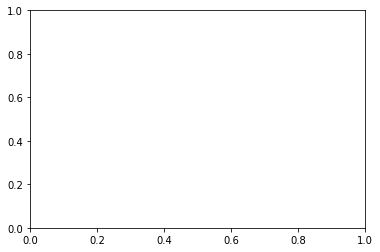

In [11]:
plt_obj(15718)

100%|██████████| 14/14 [03:12<00:00, 13.72s/it]


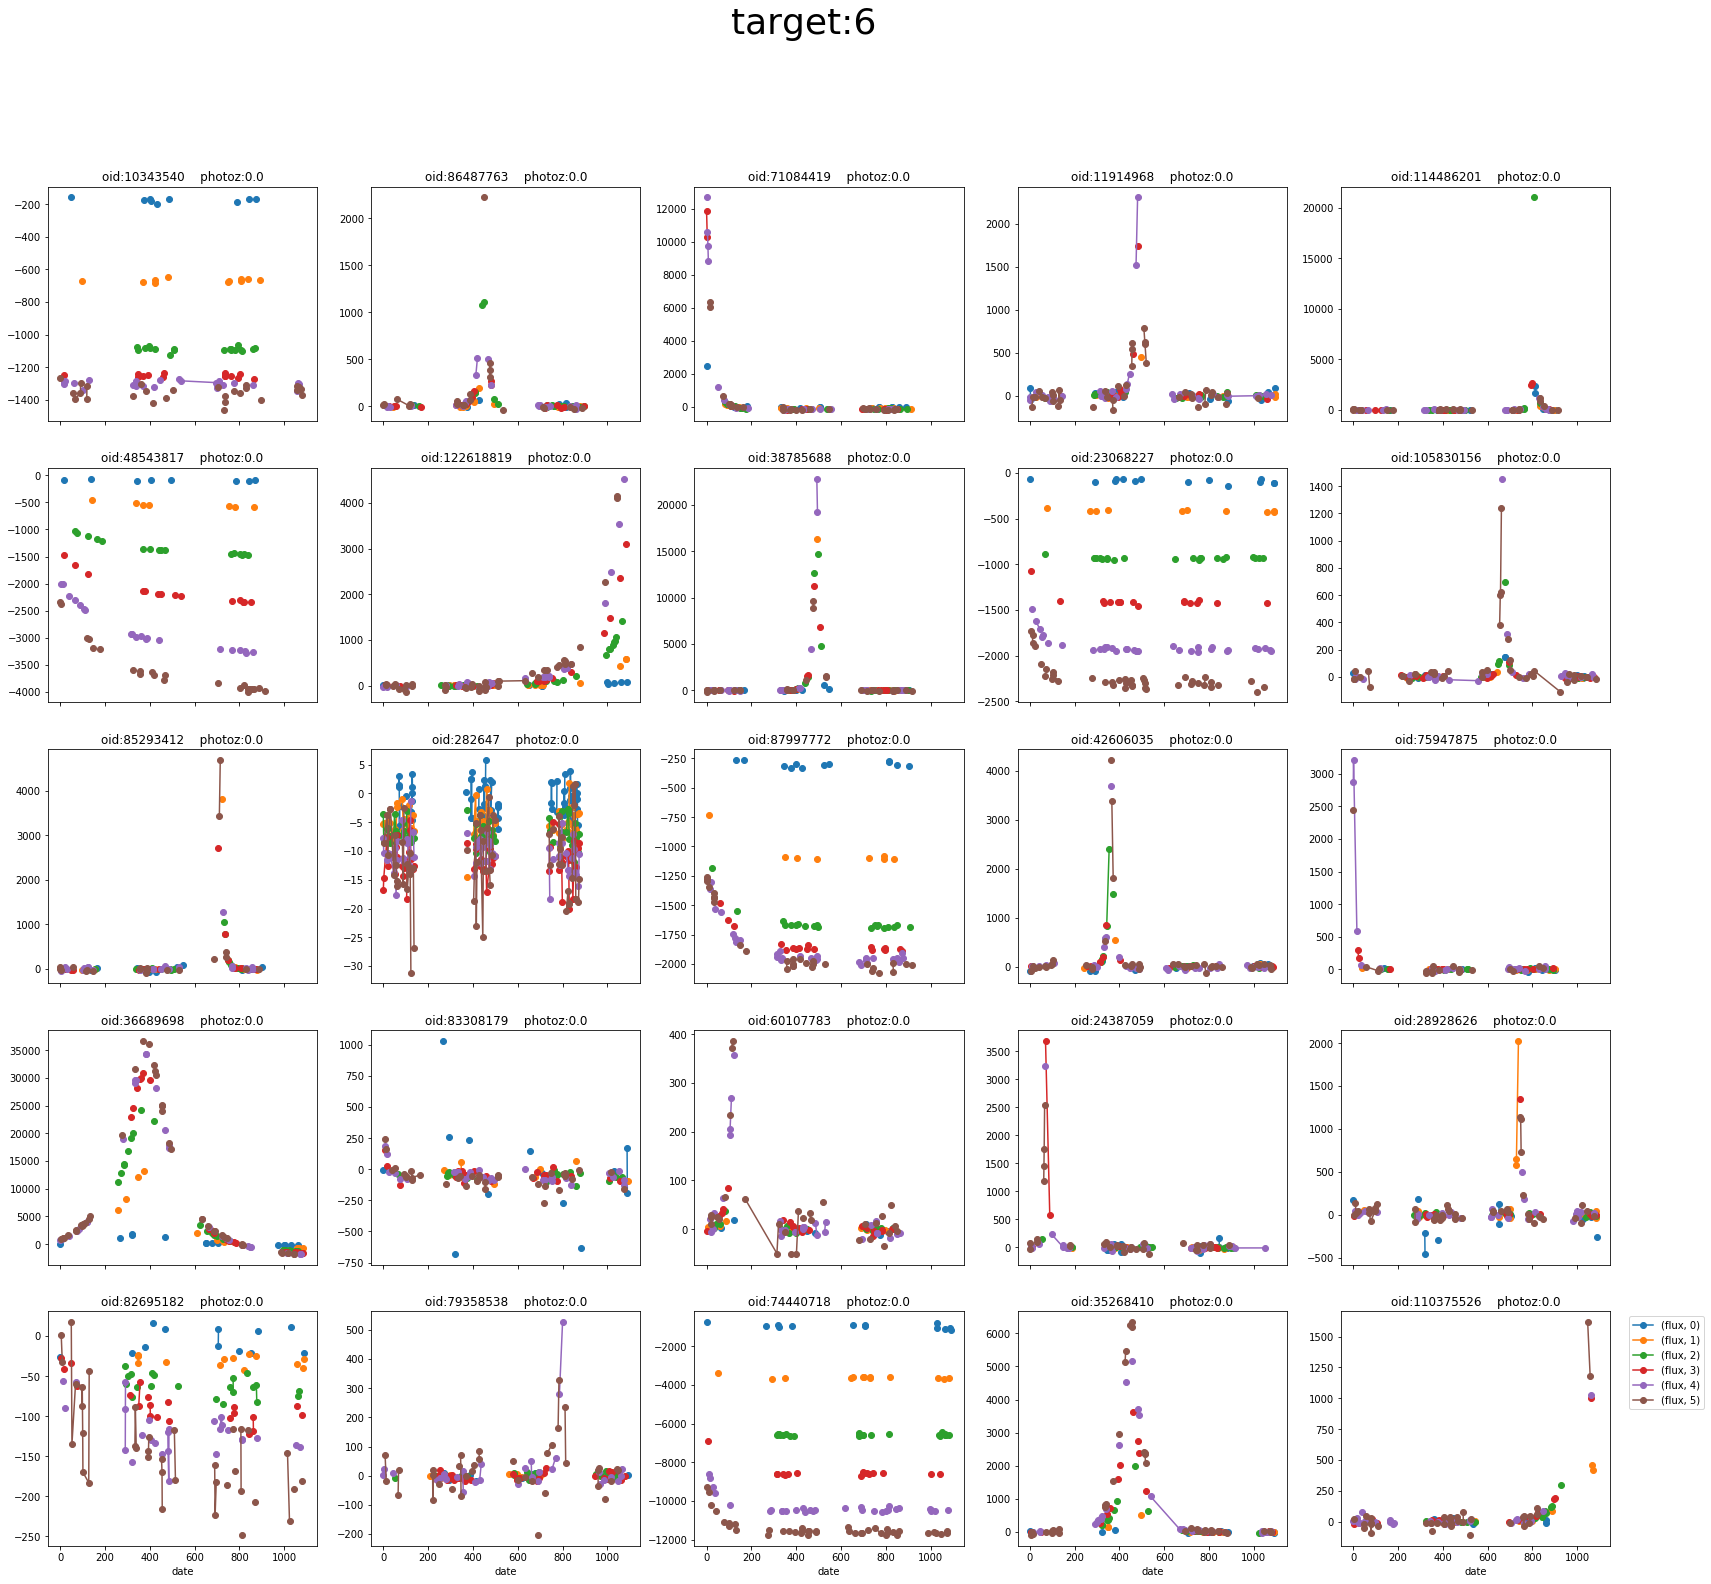

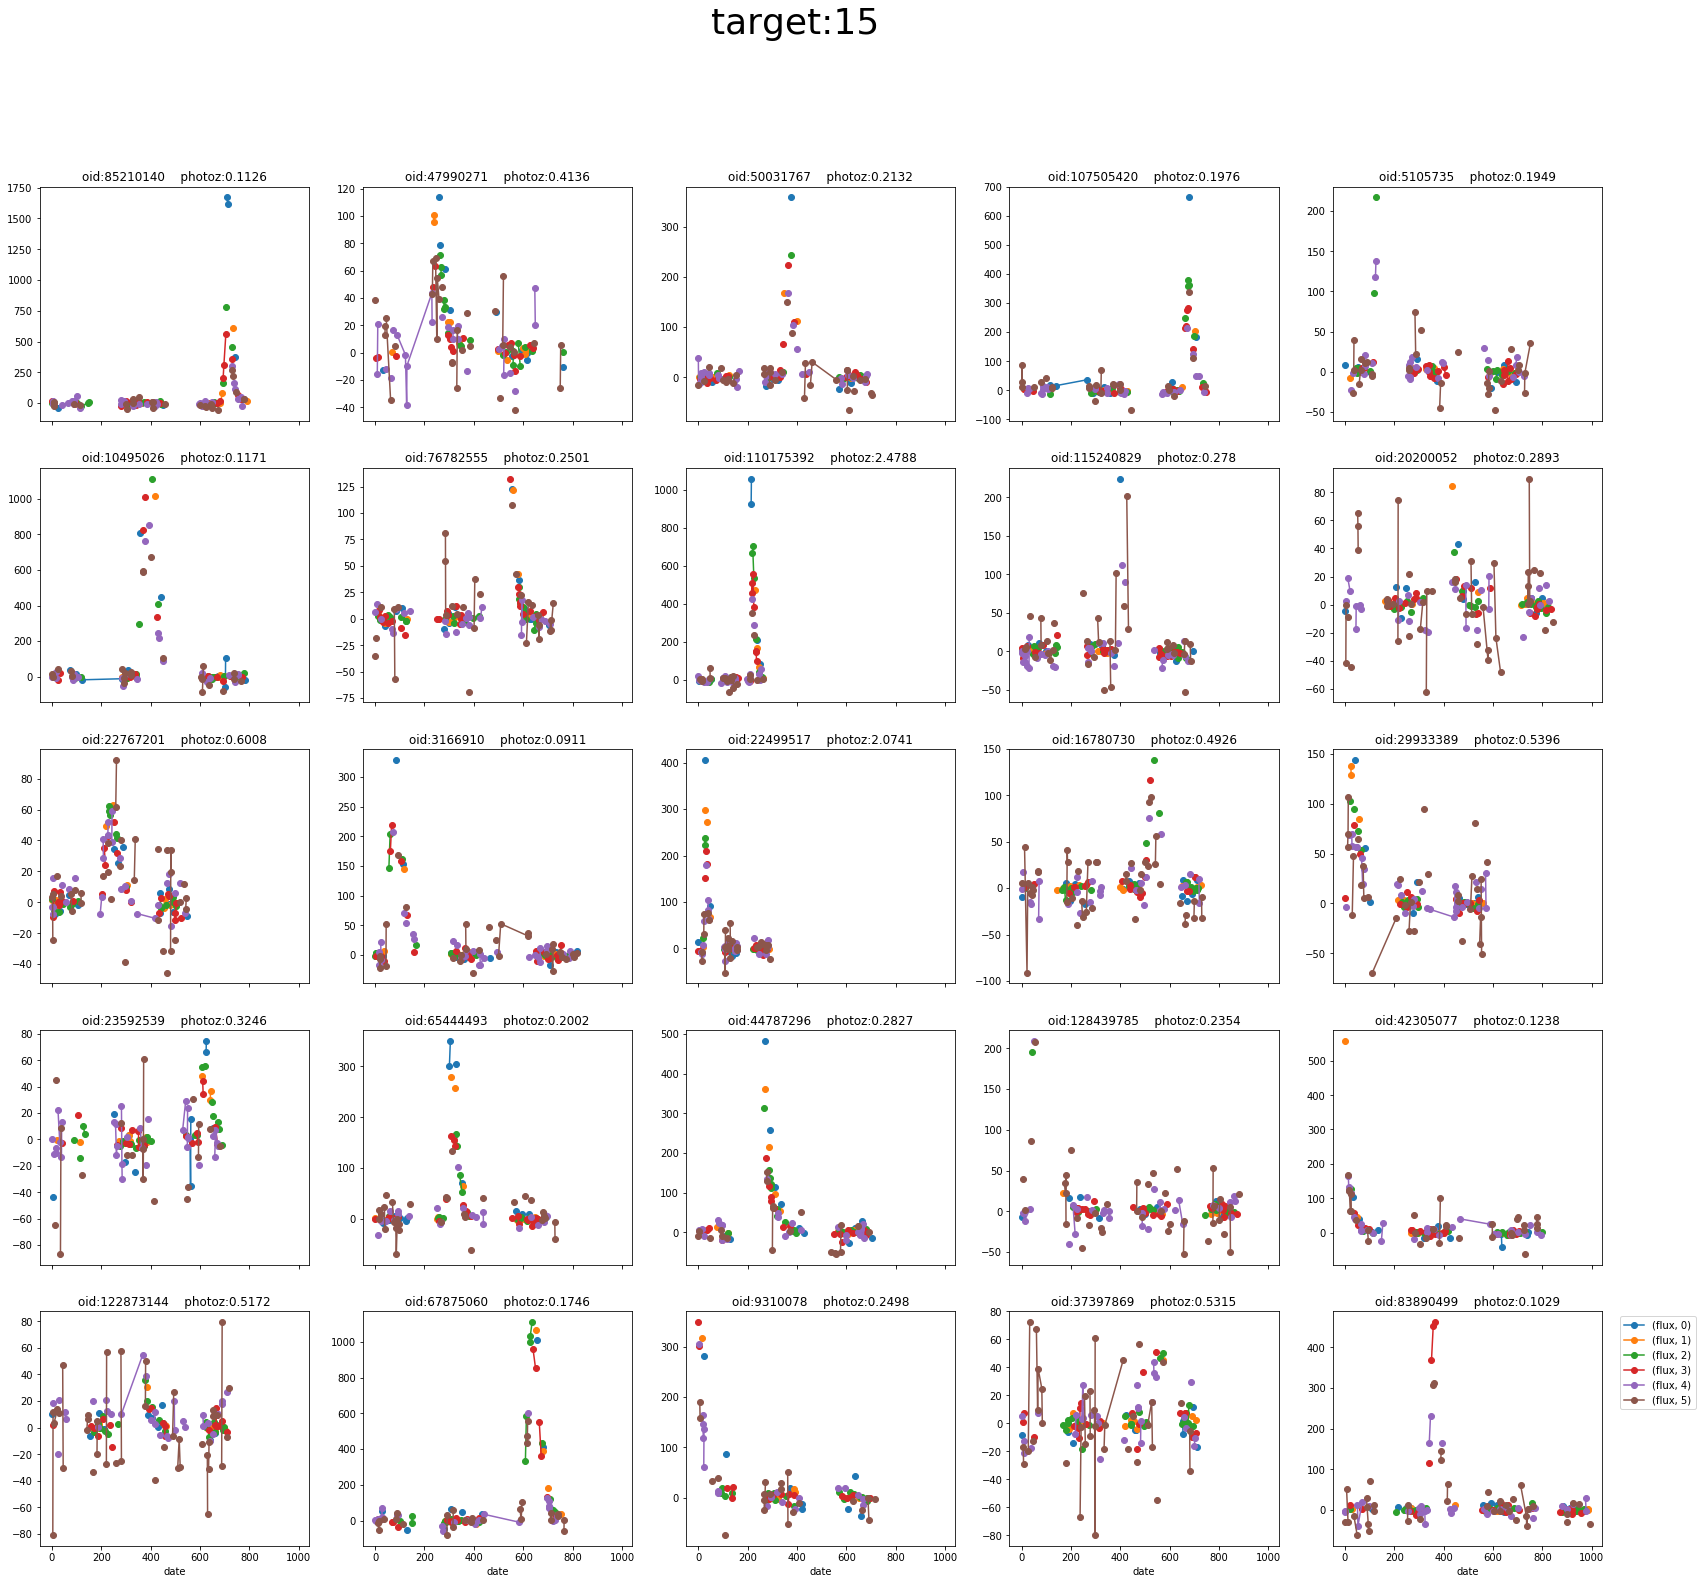

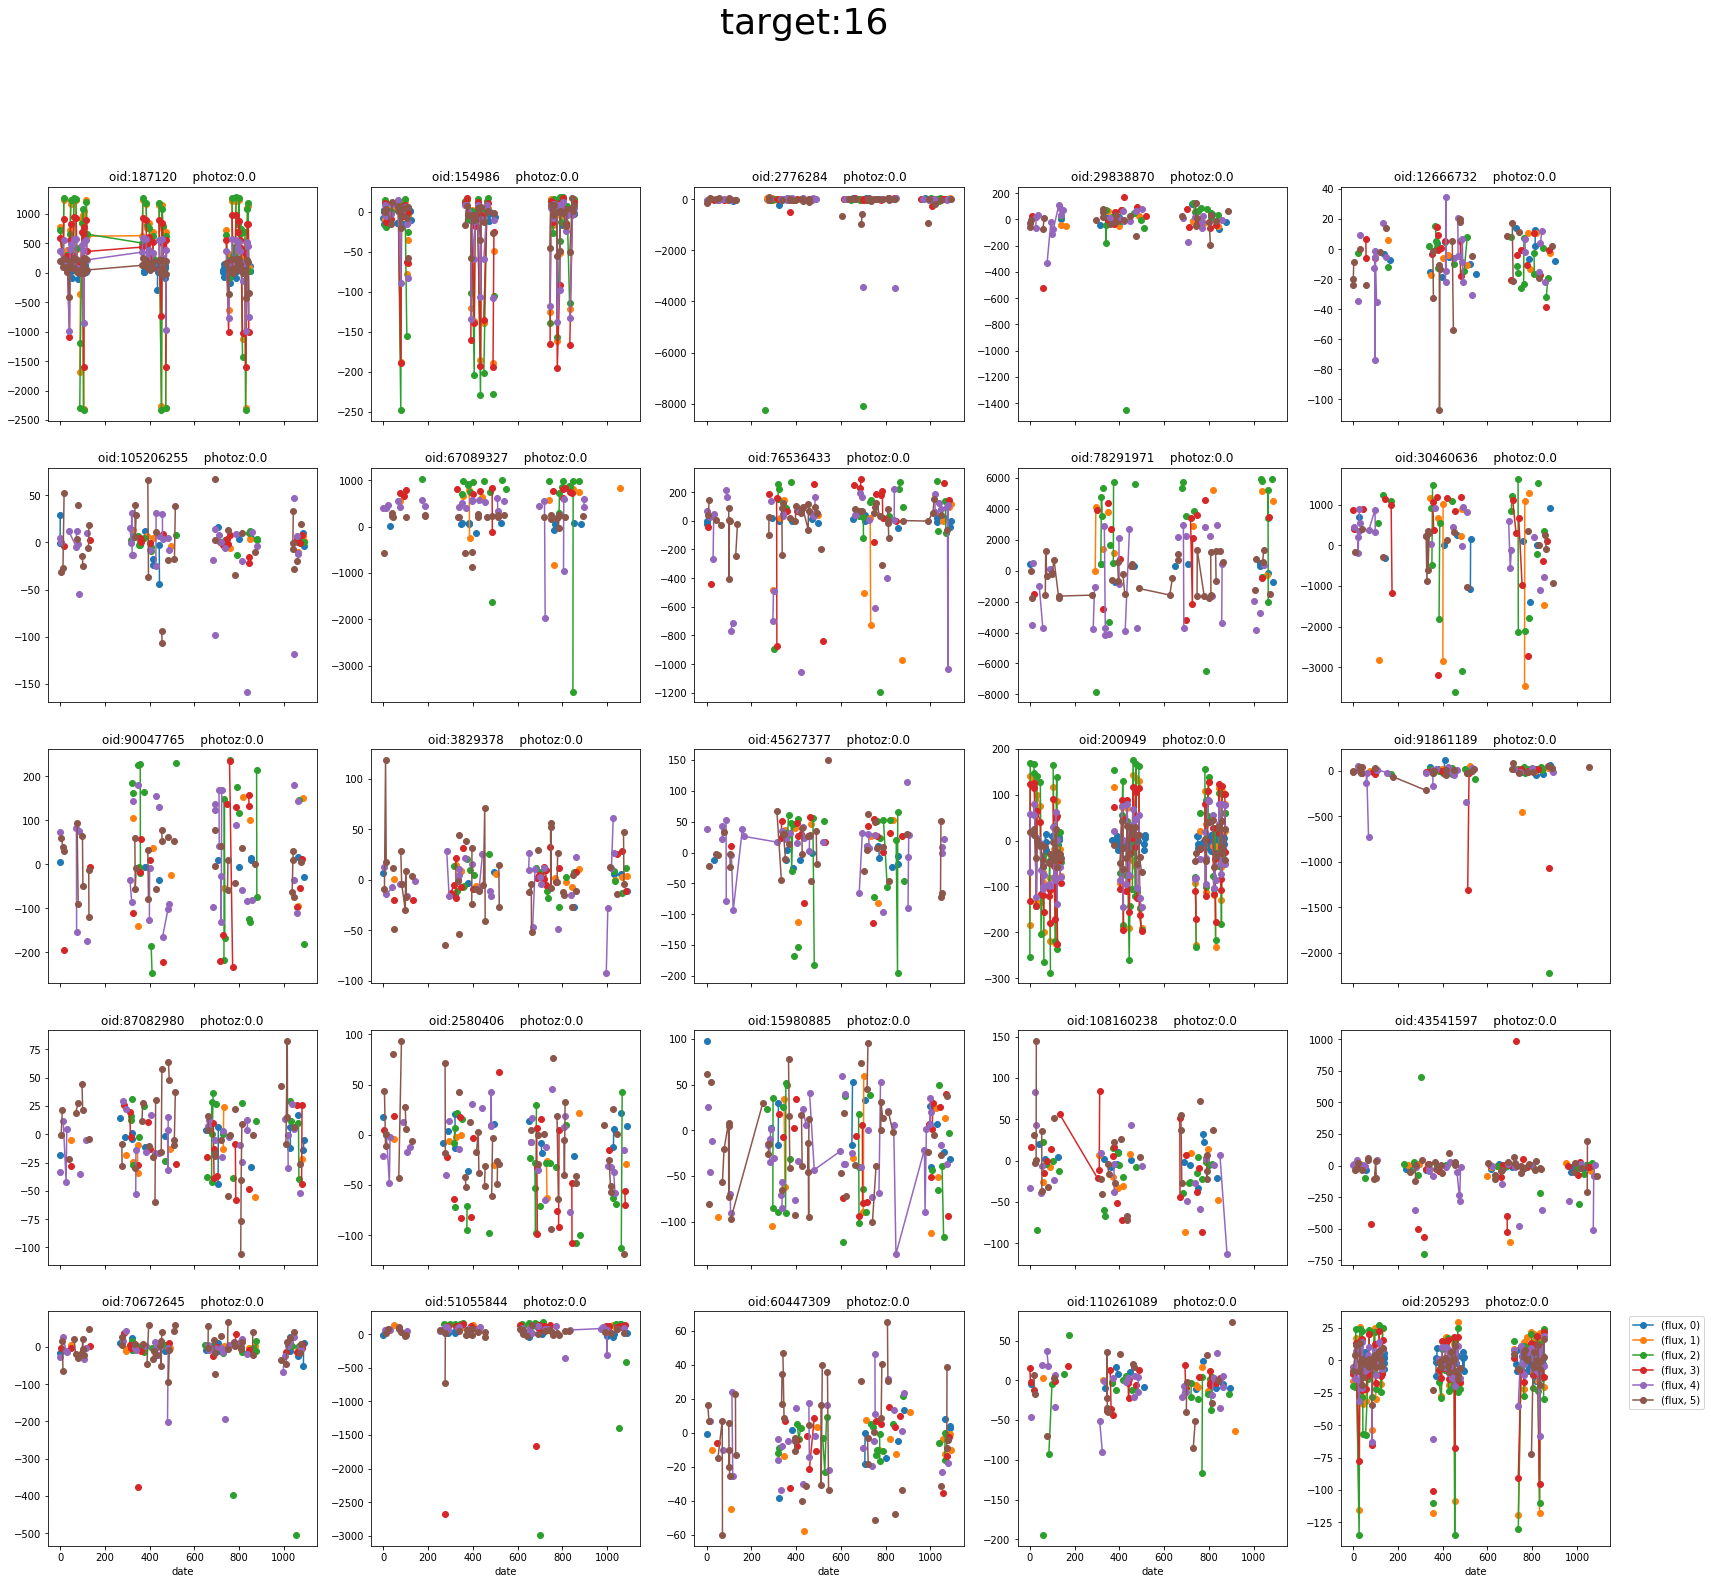

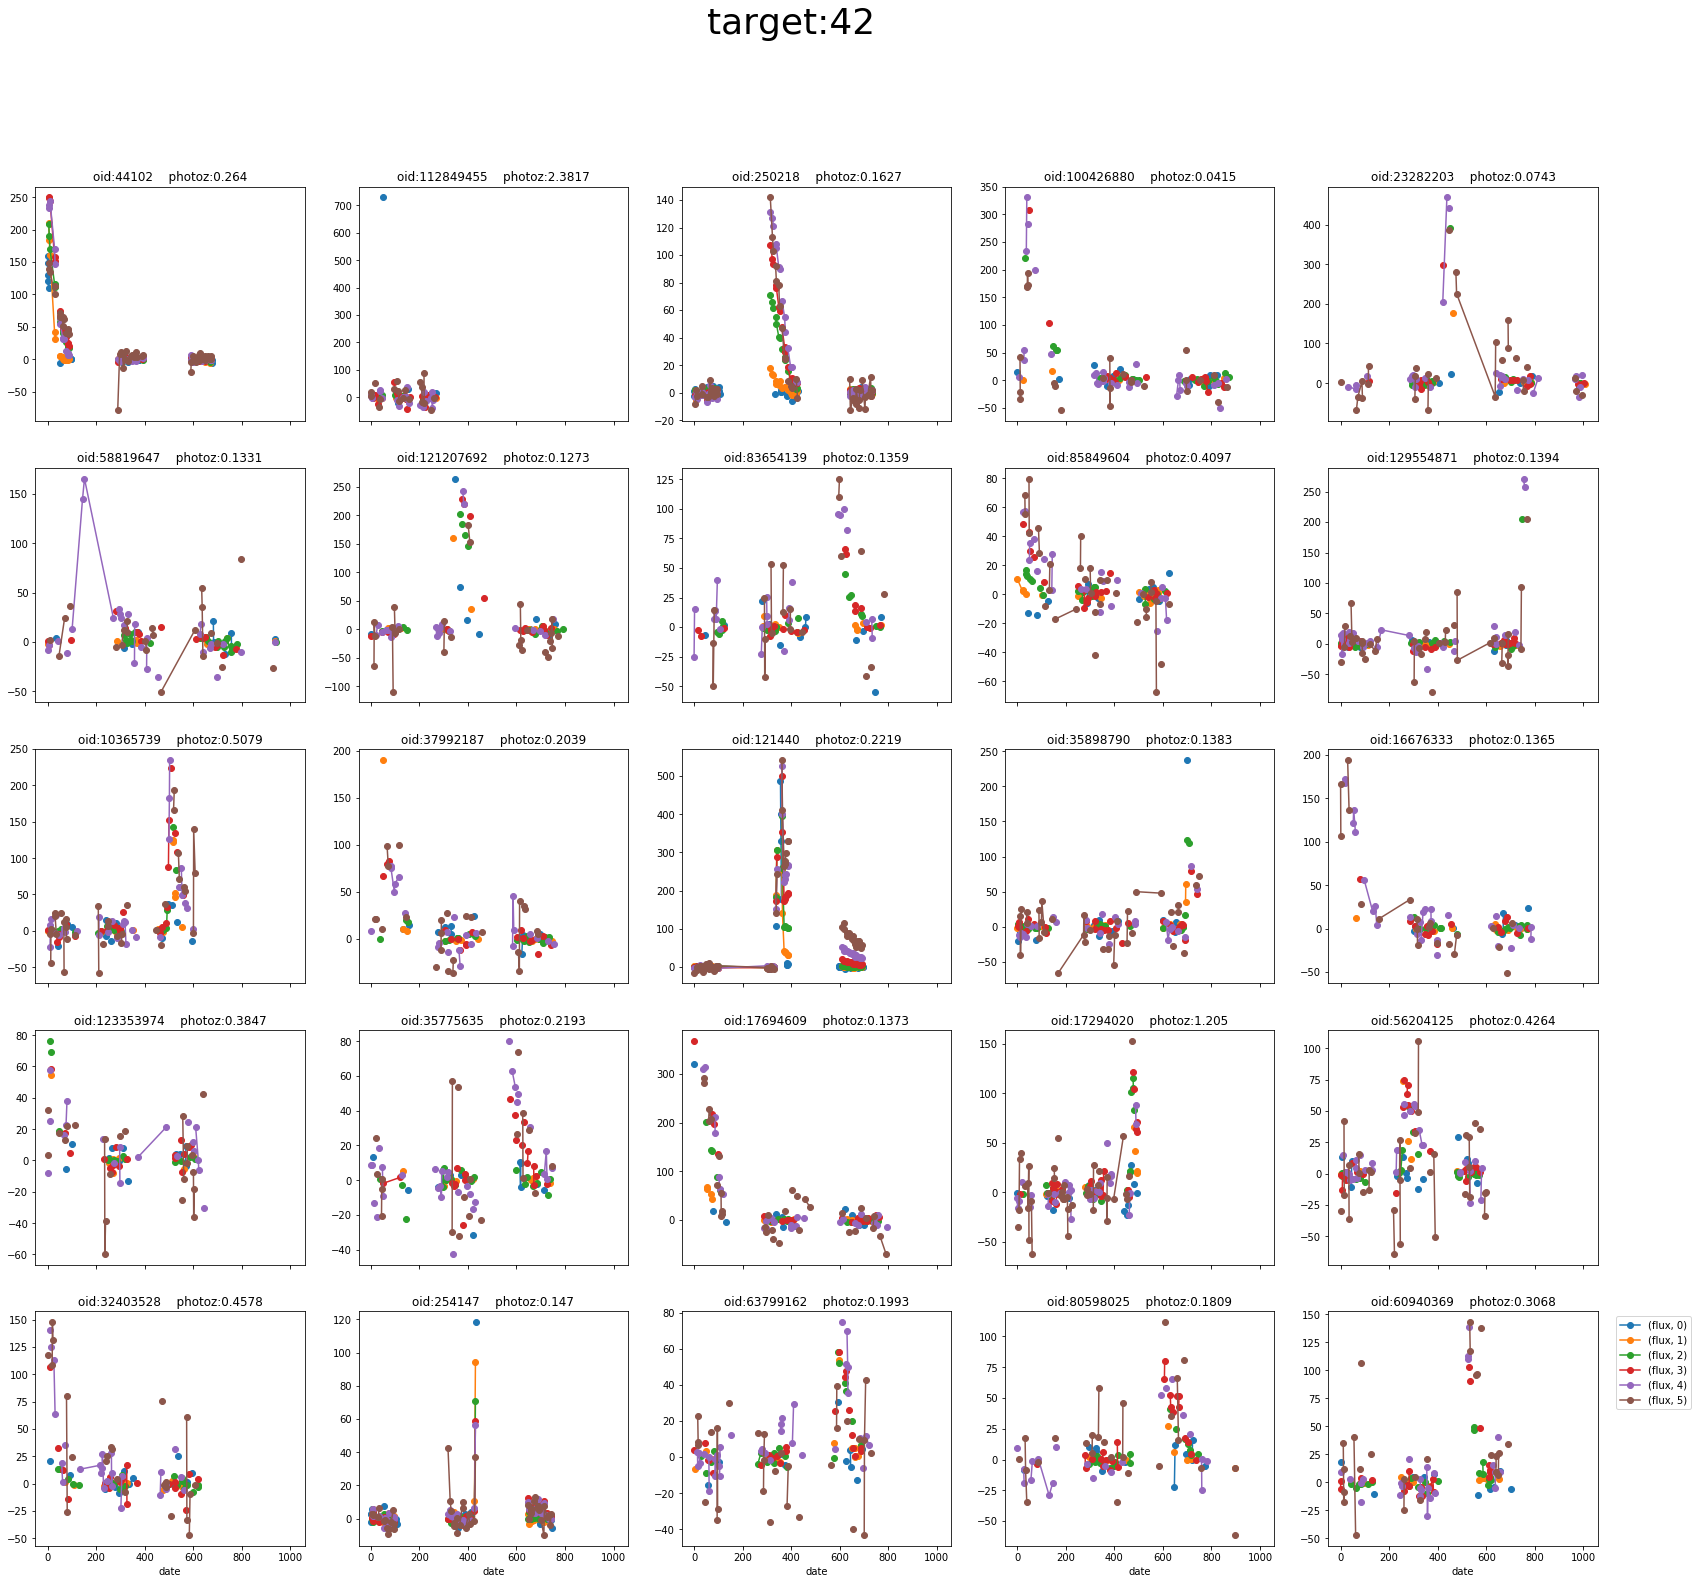

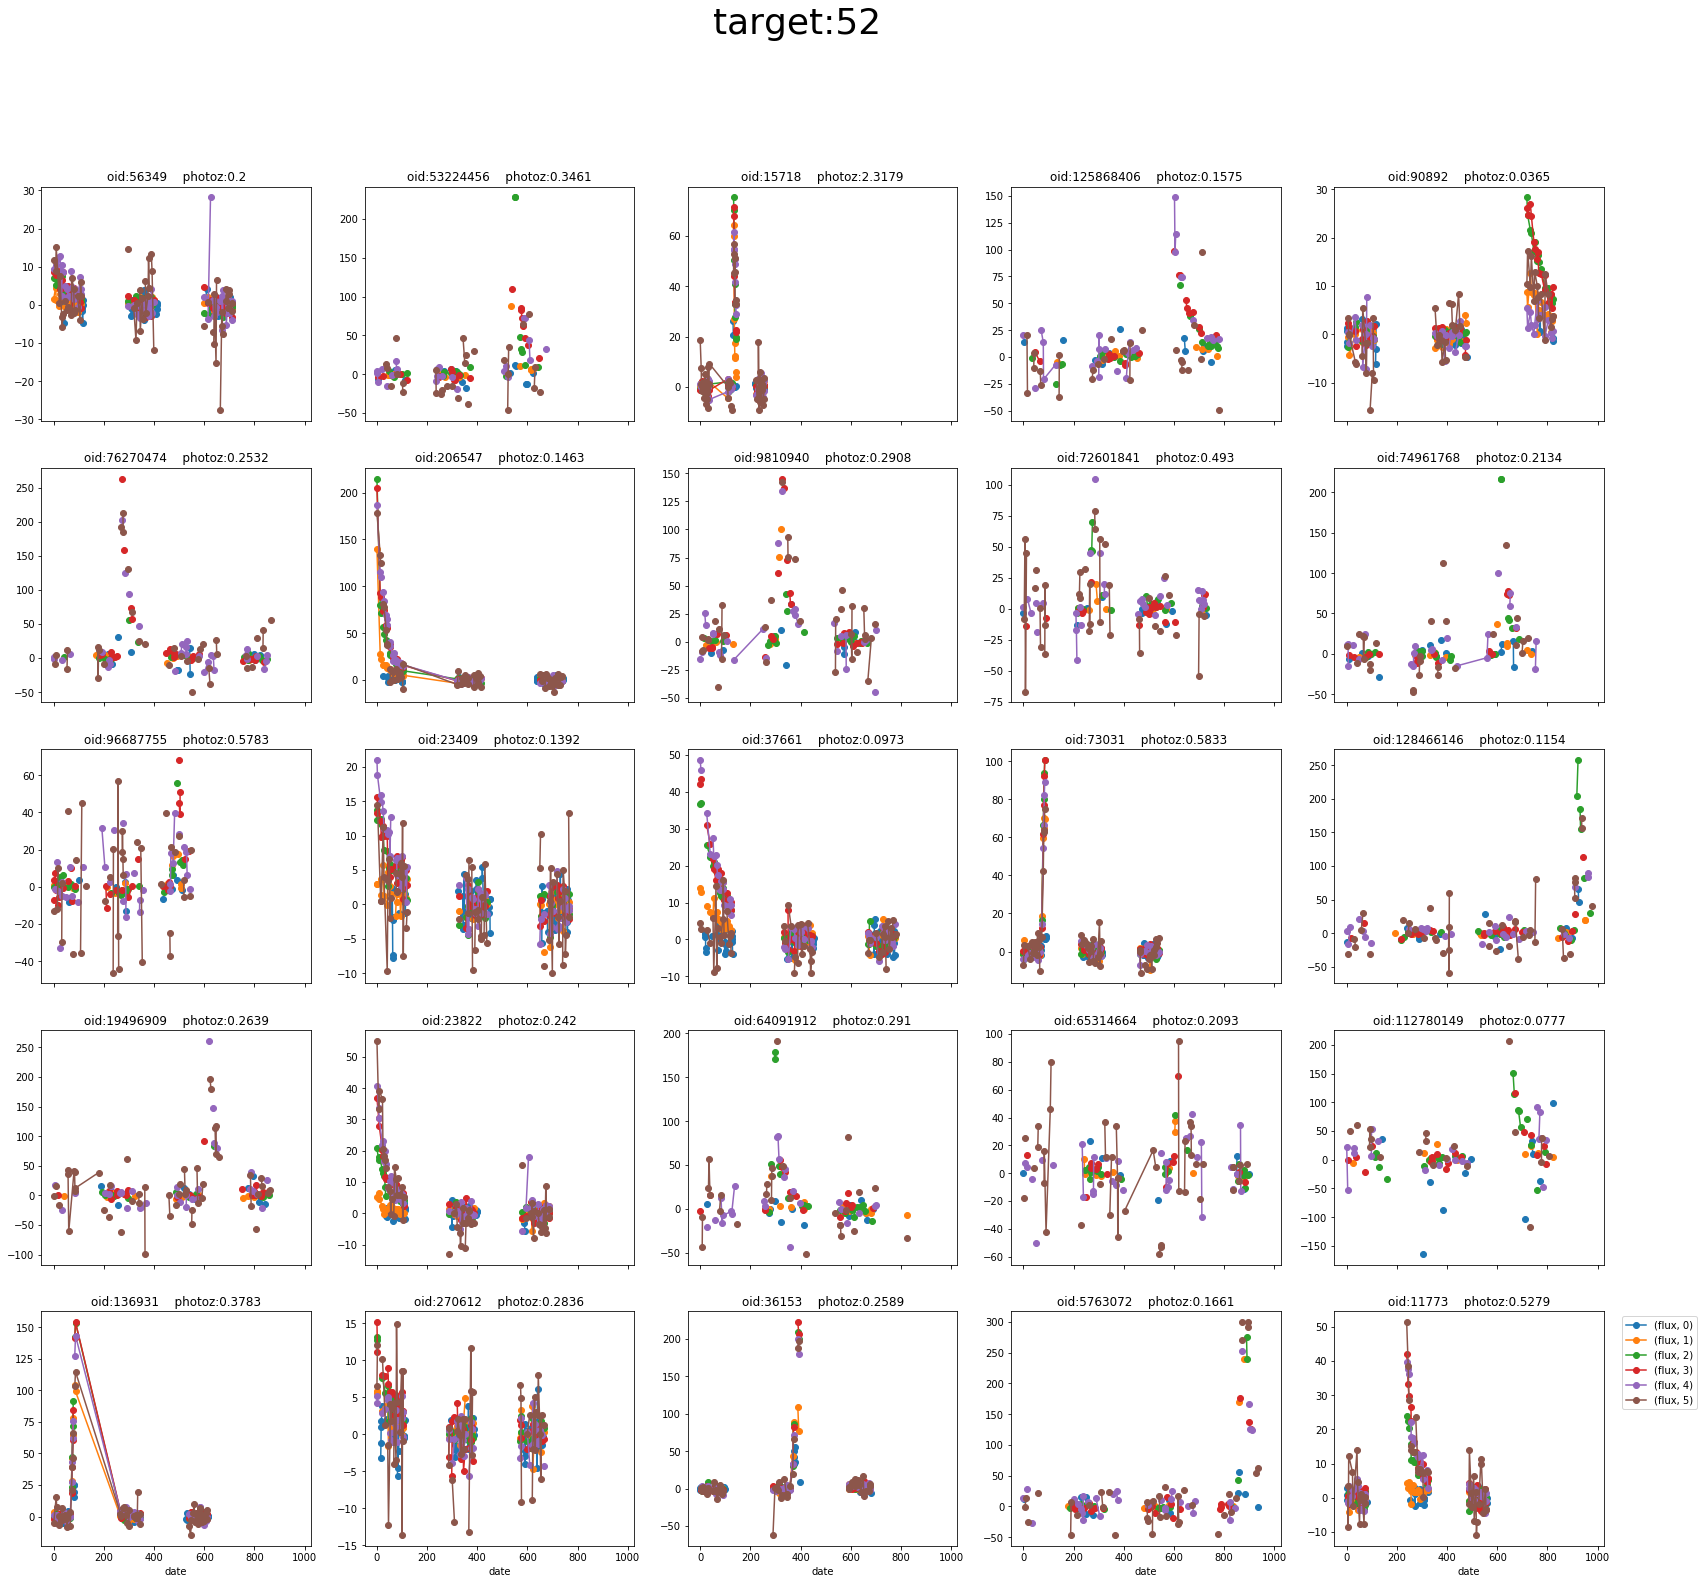

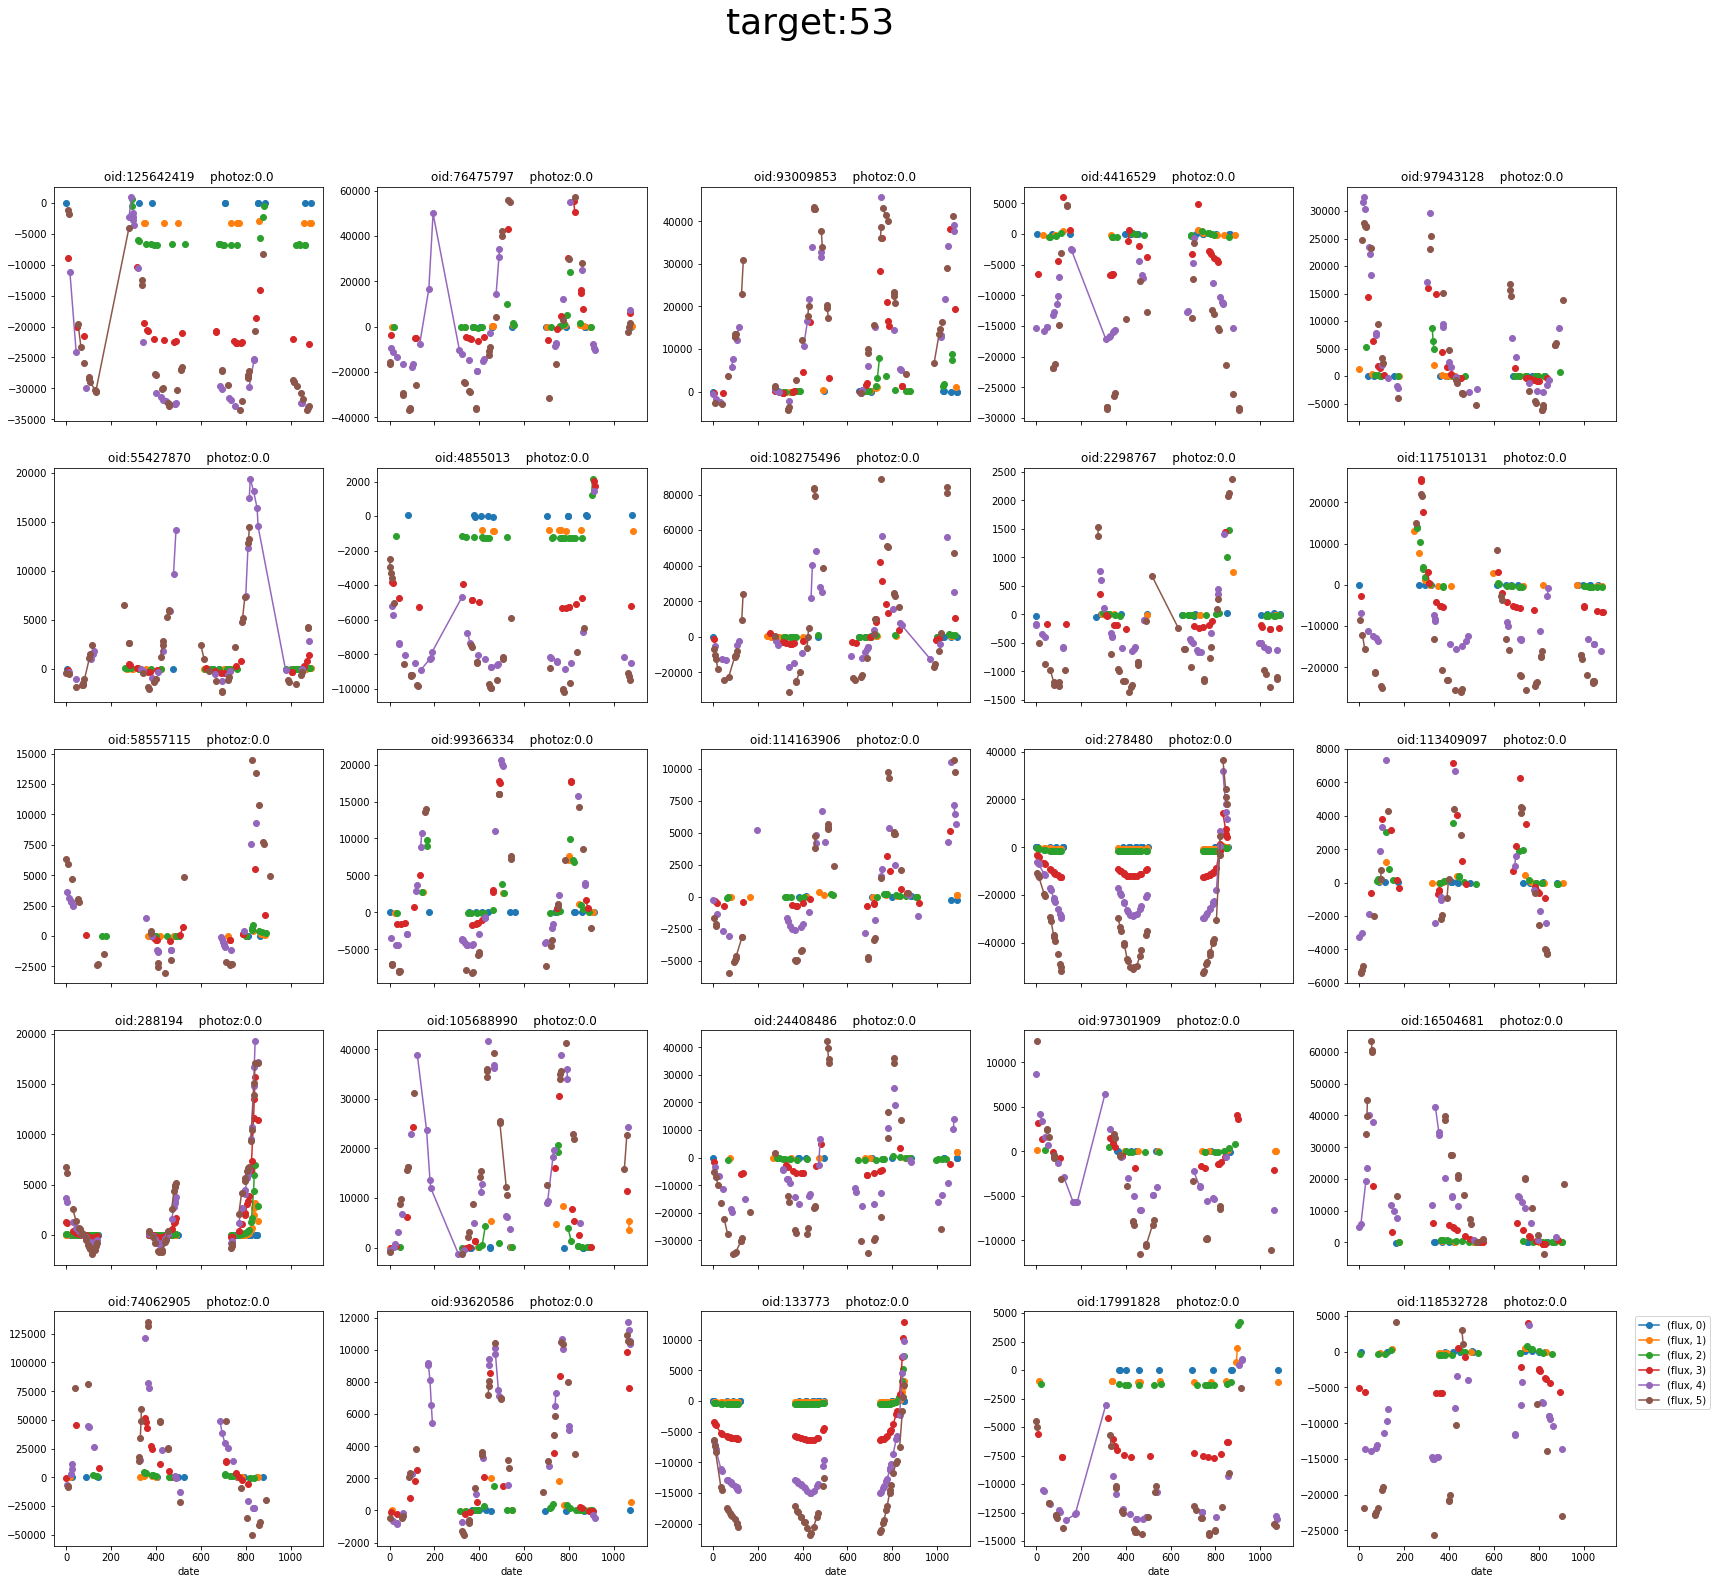

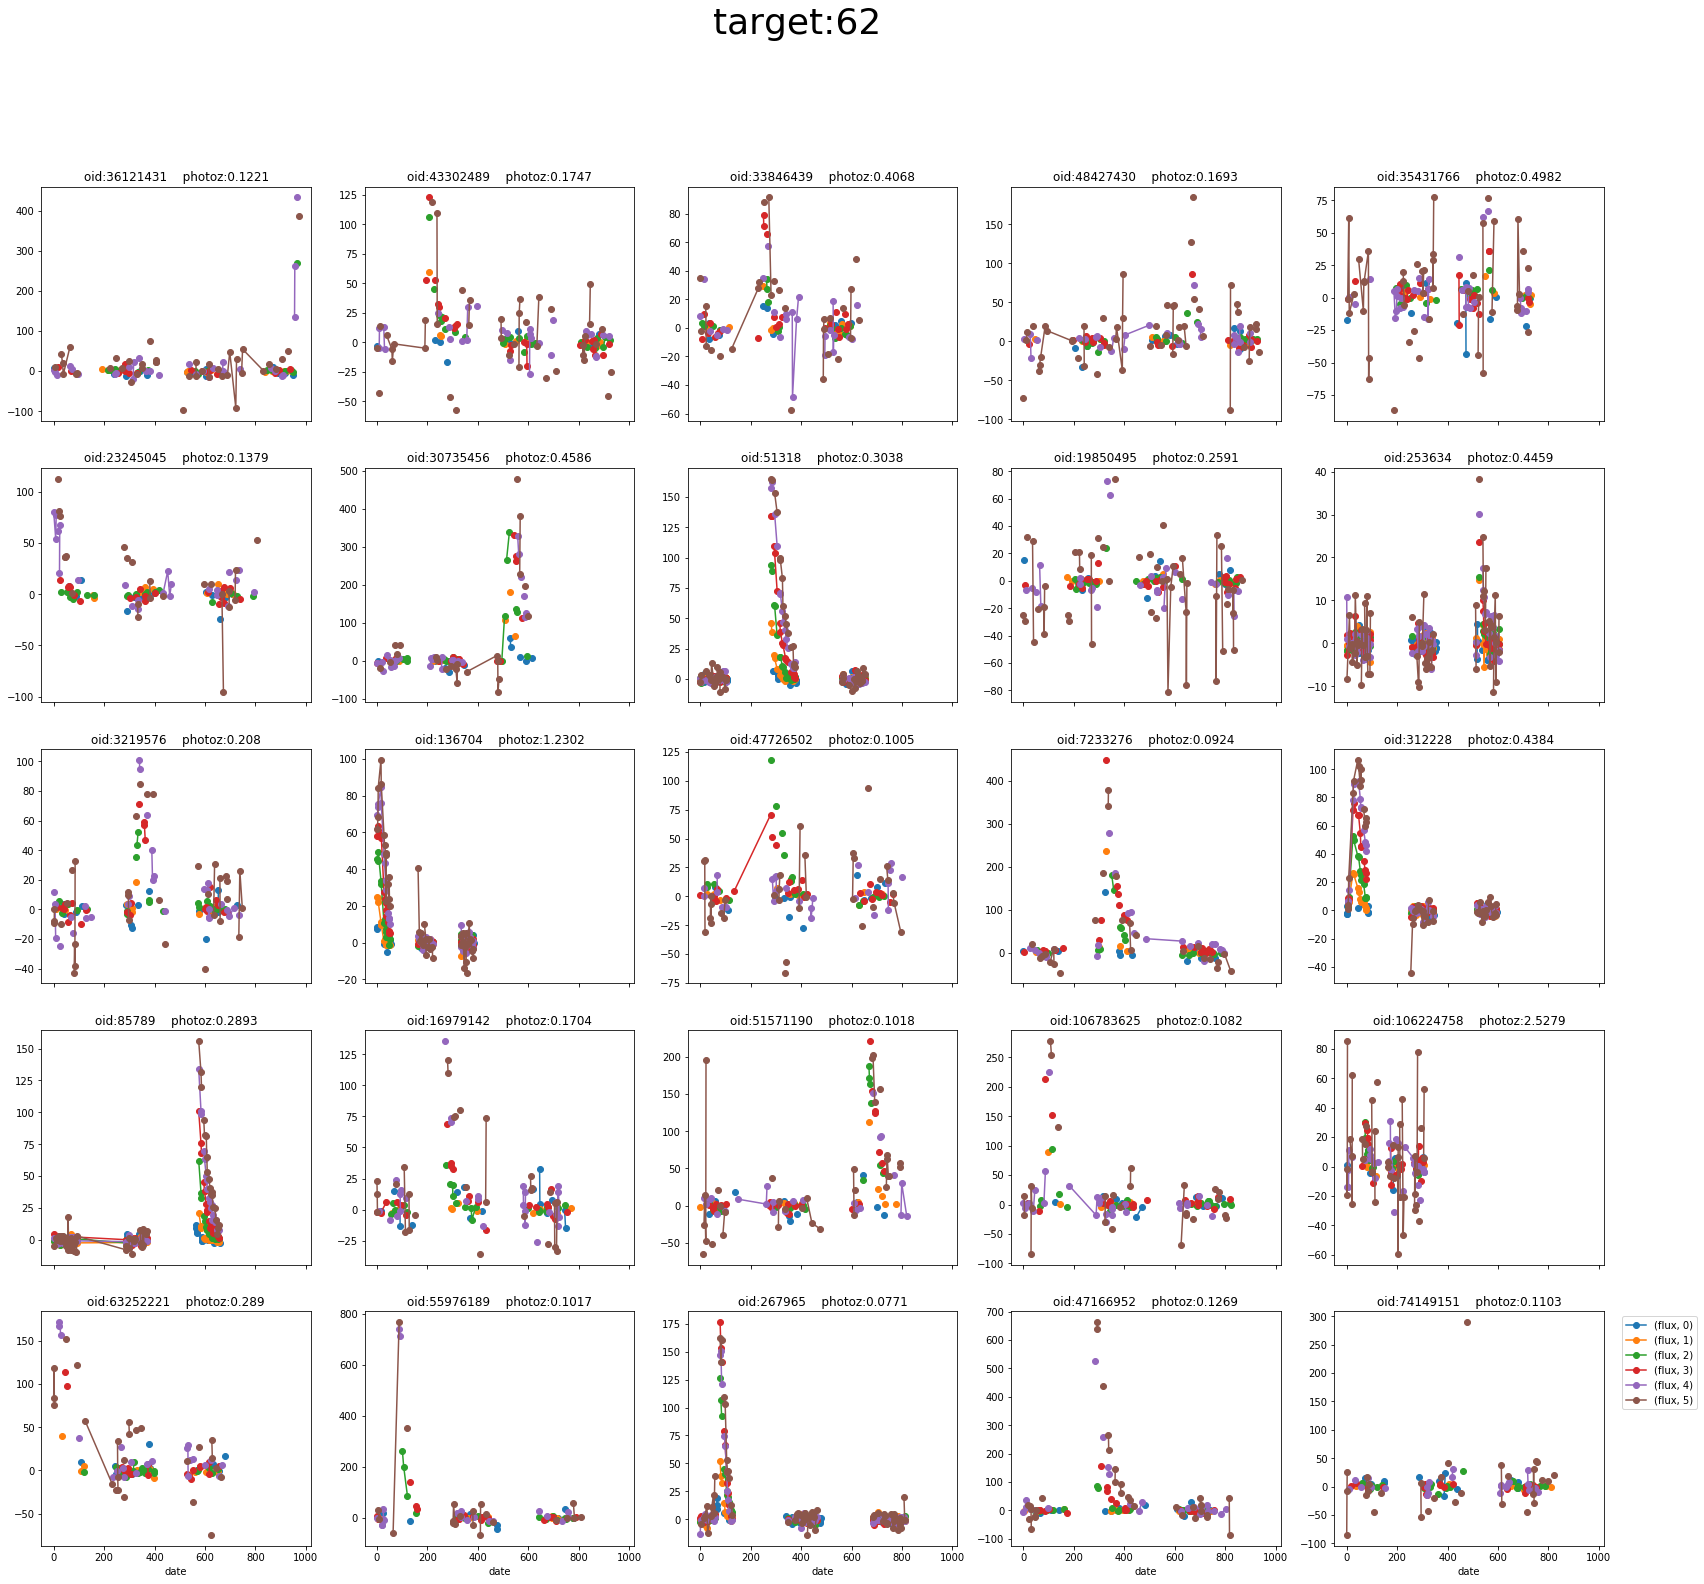

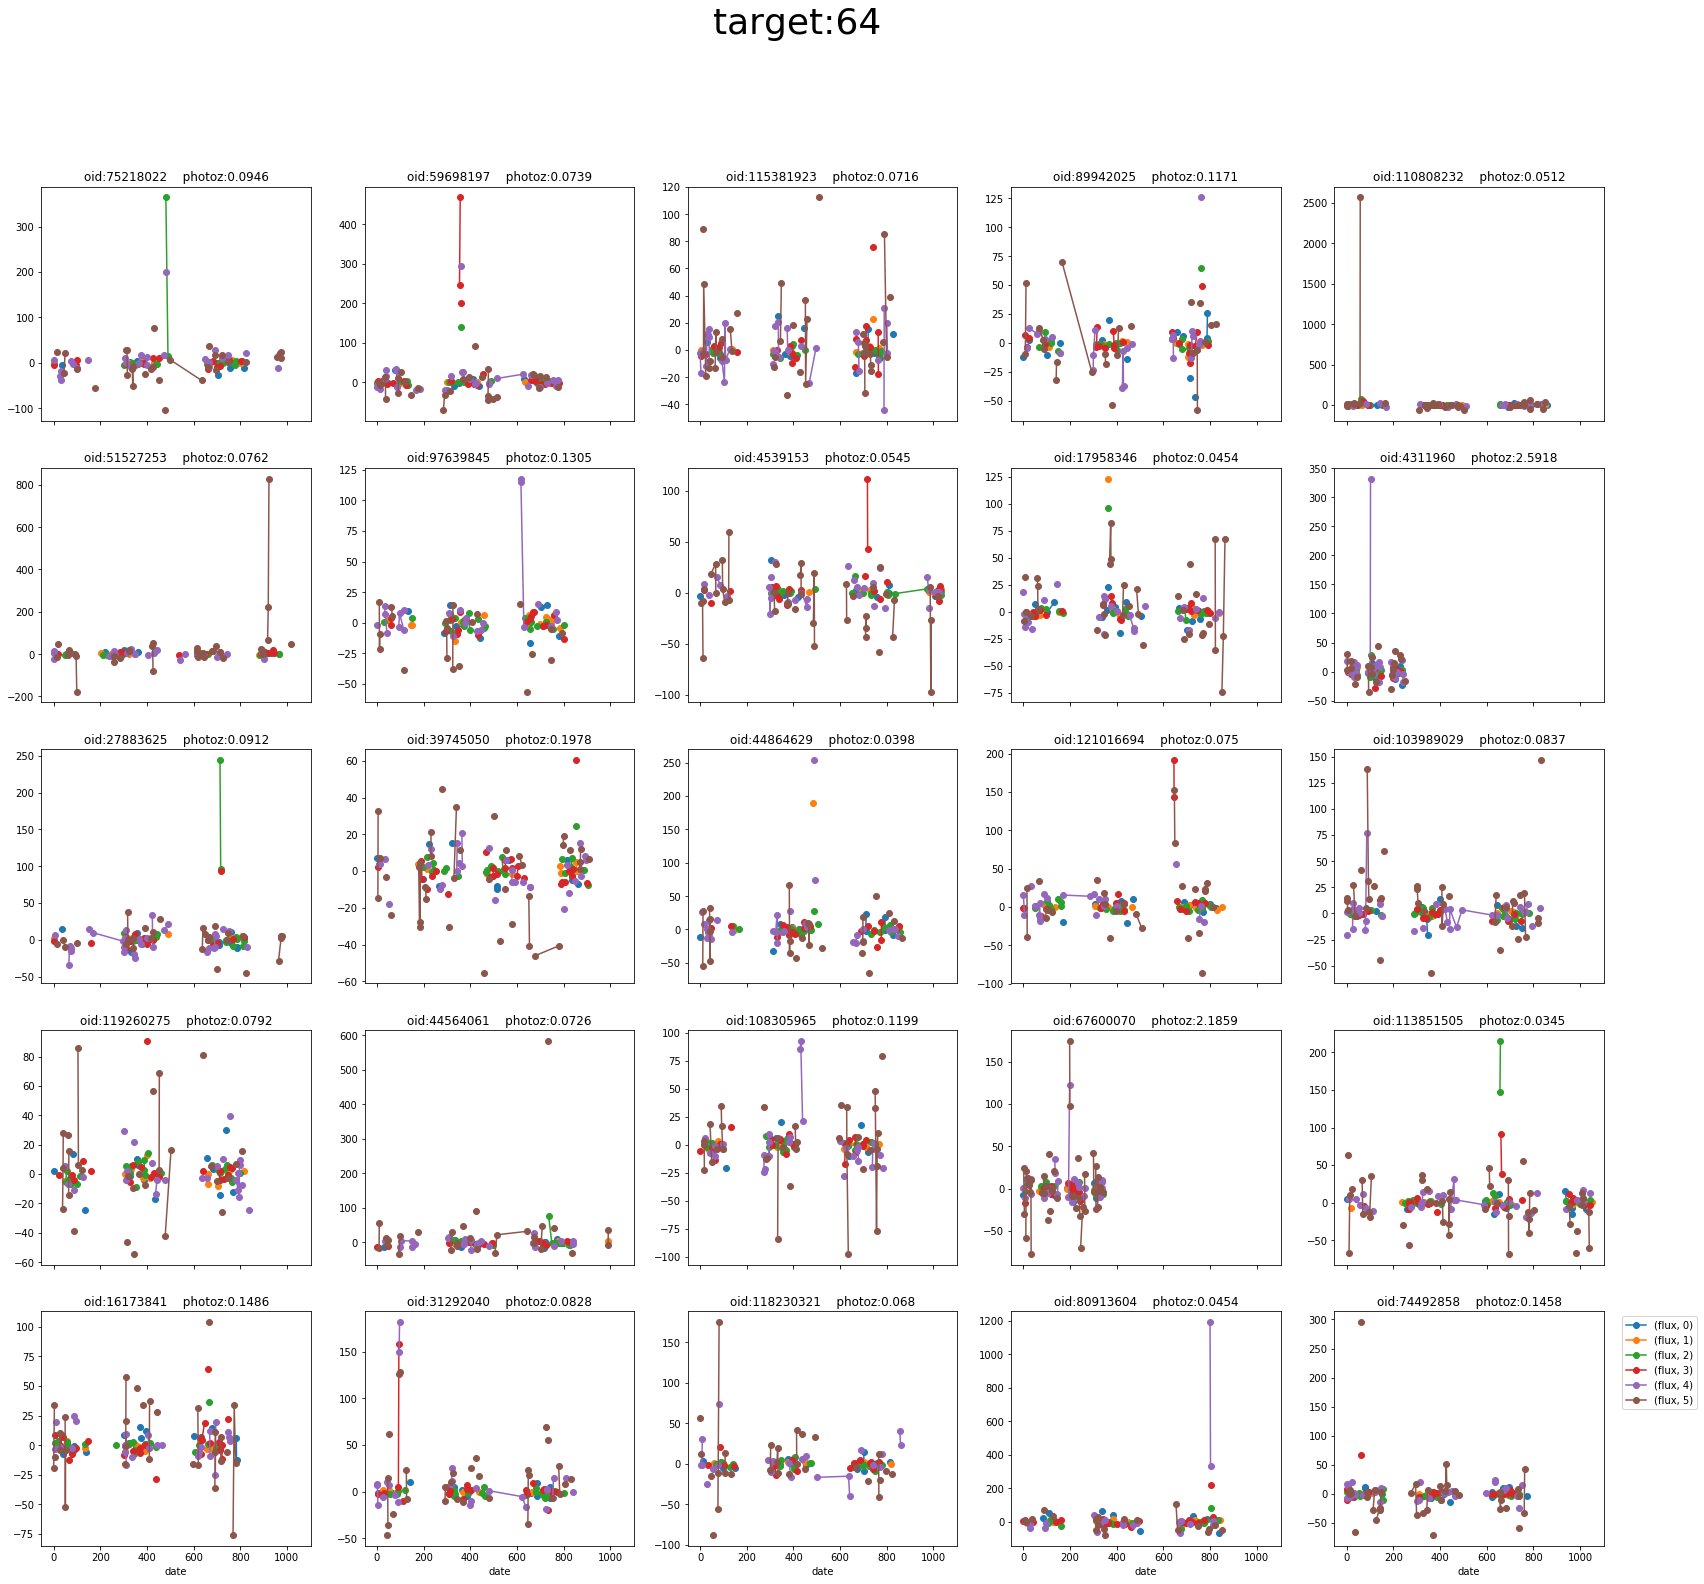

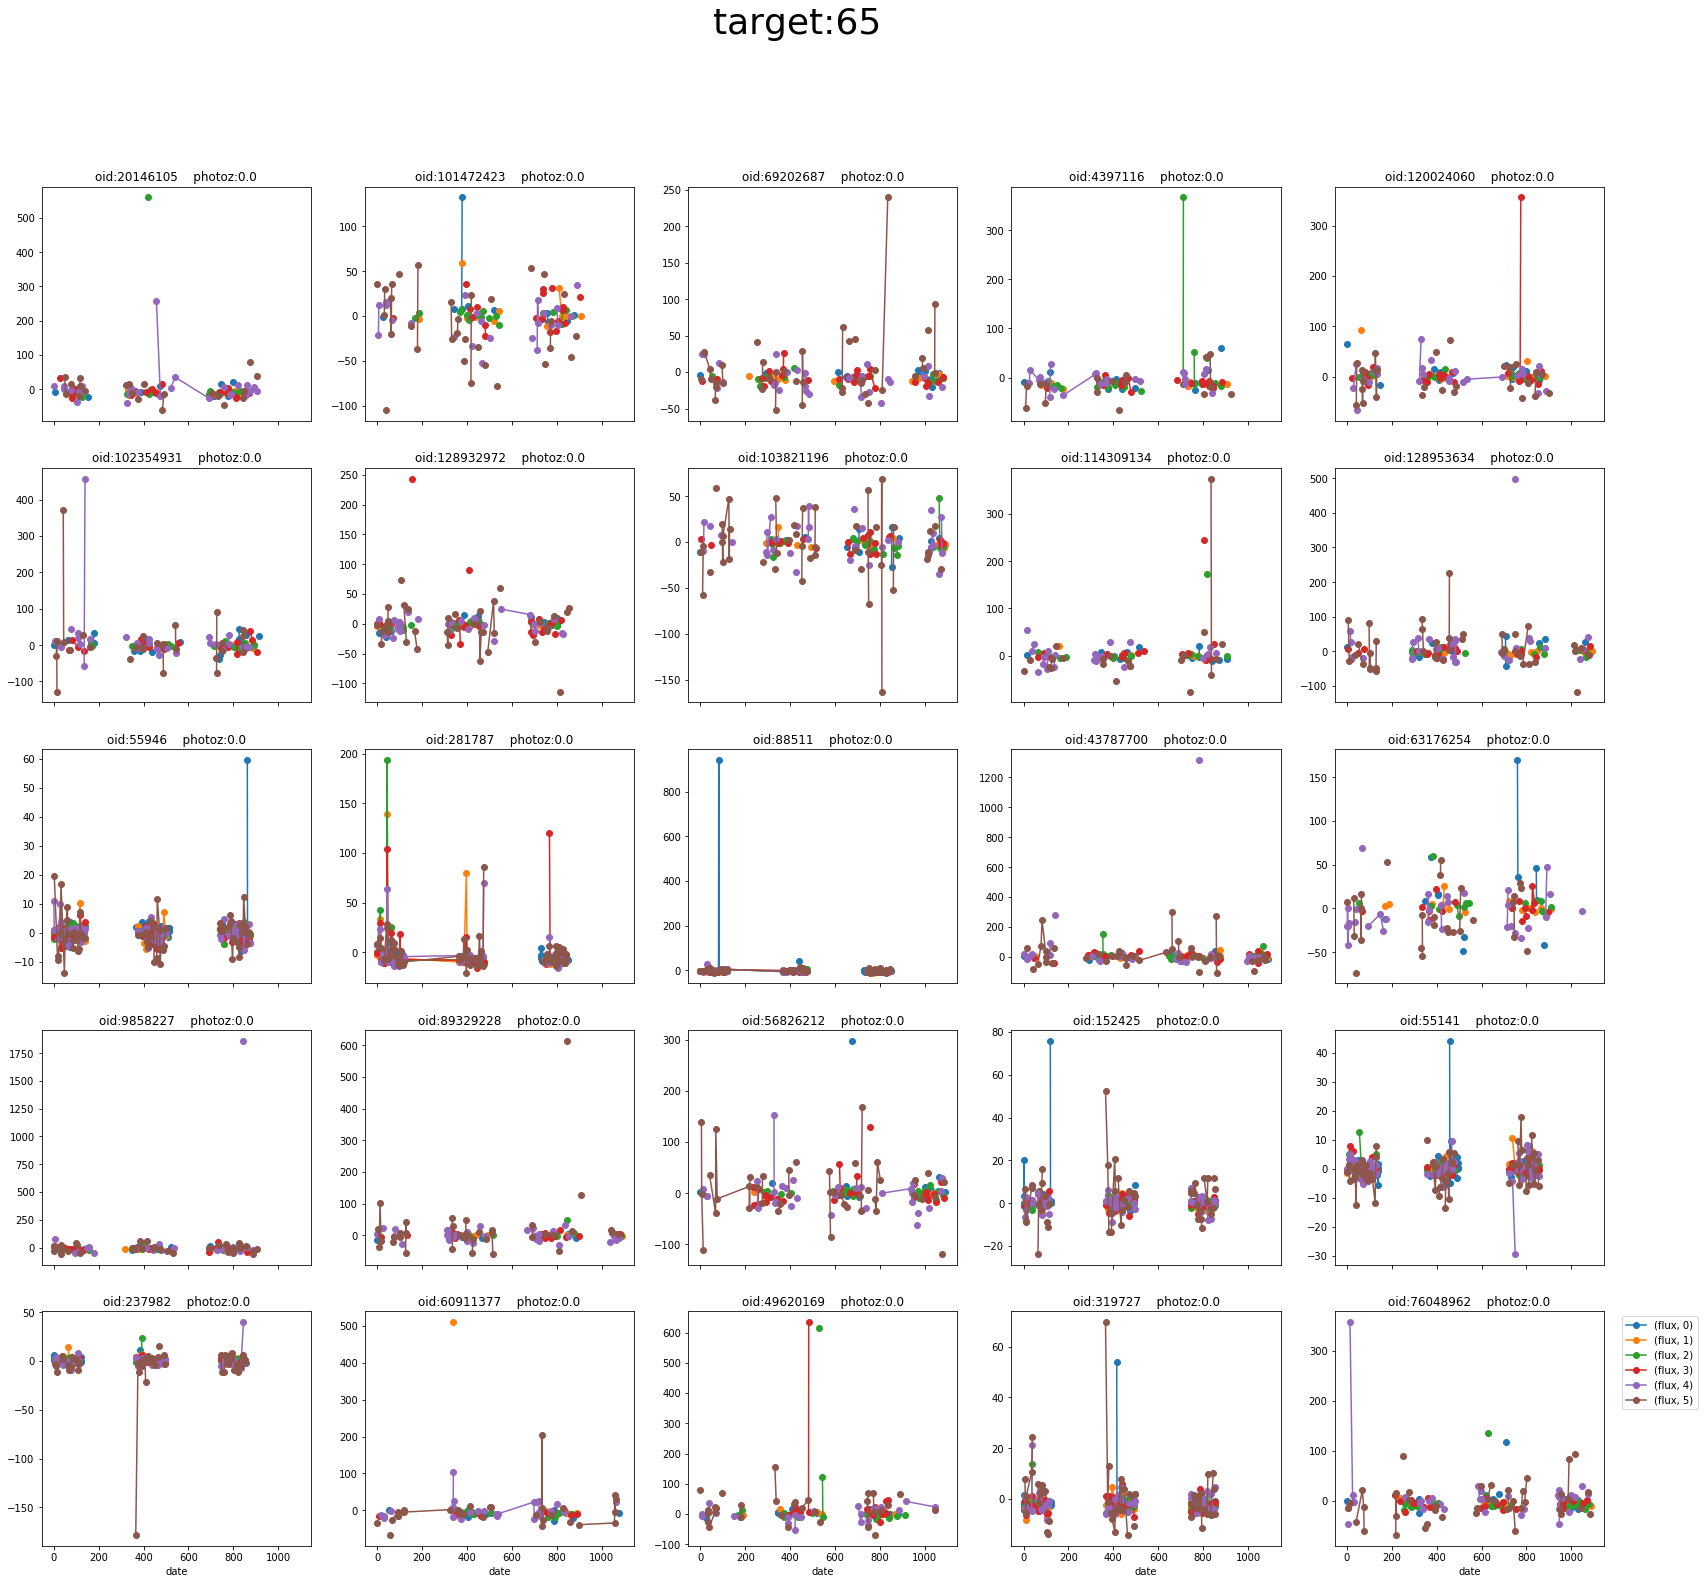

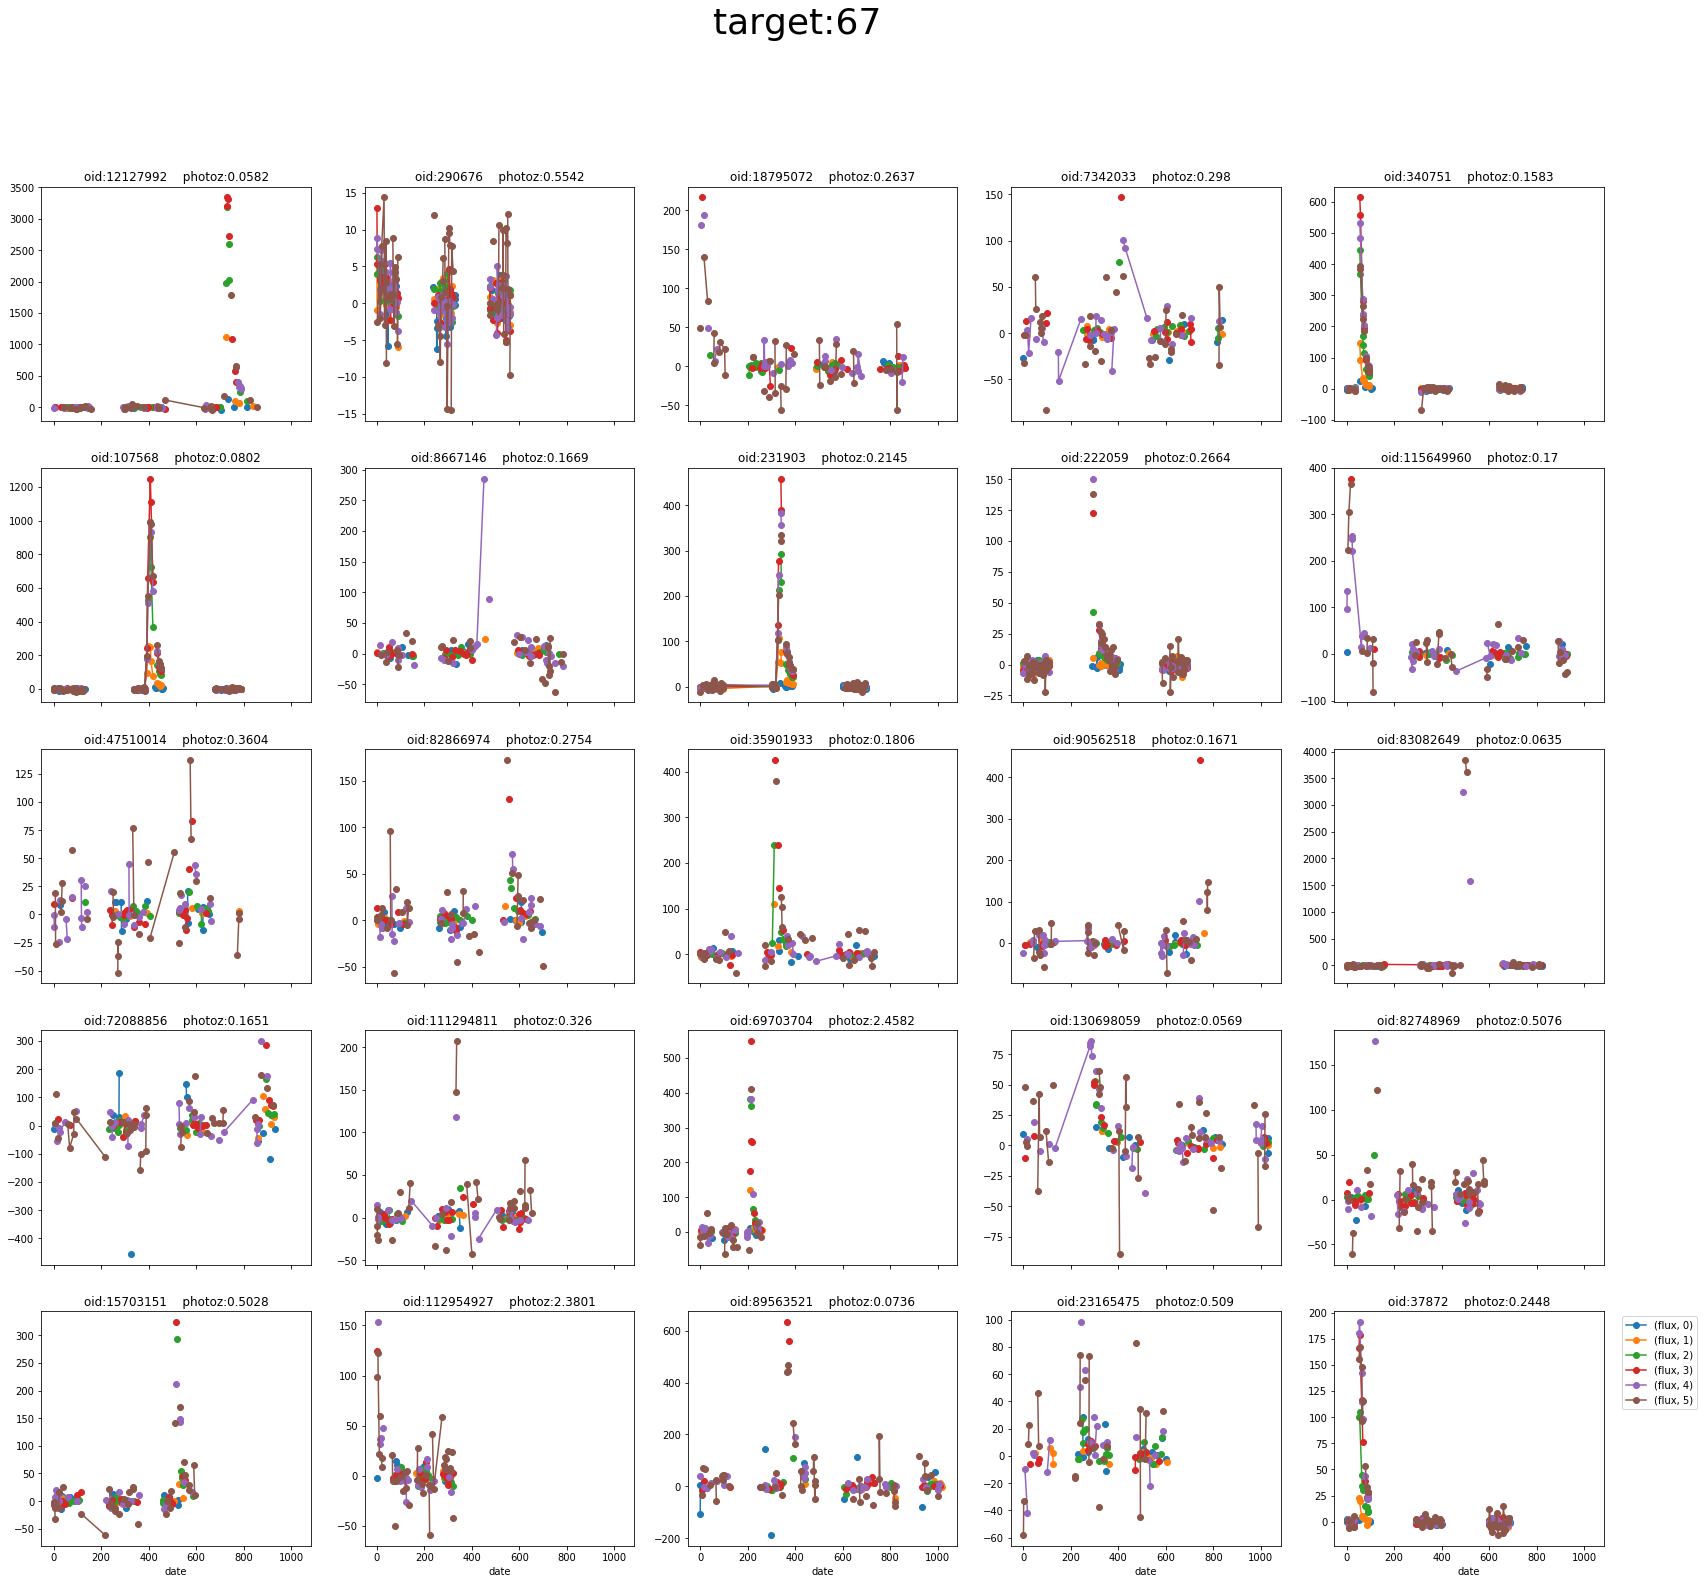

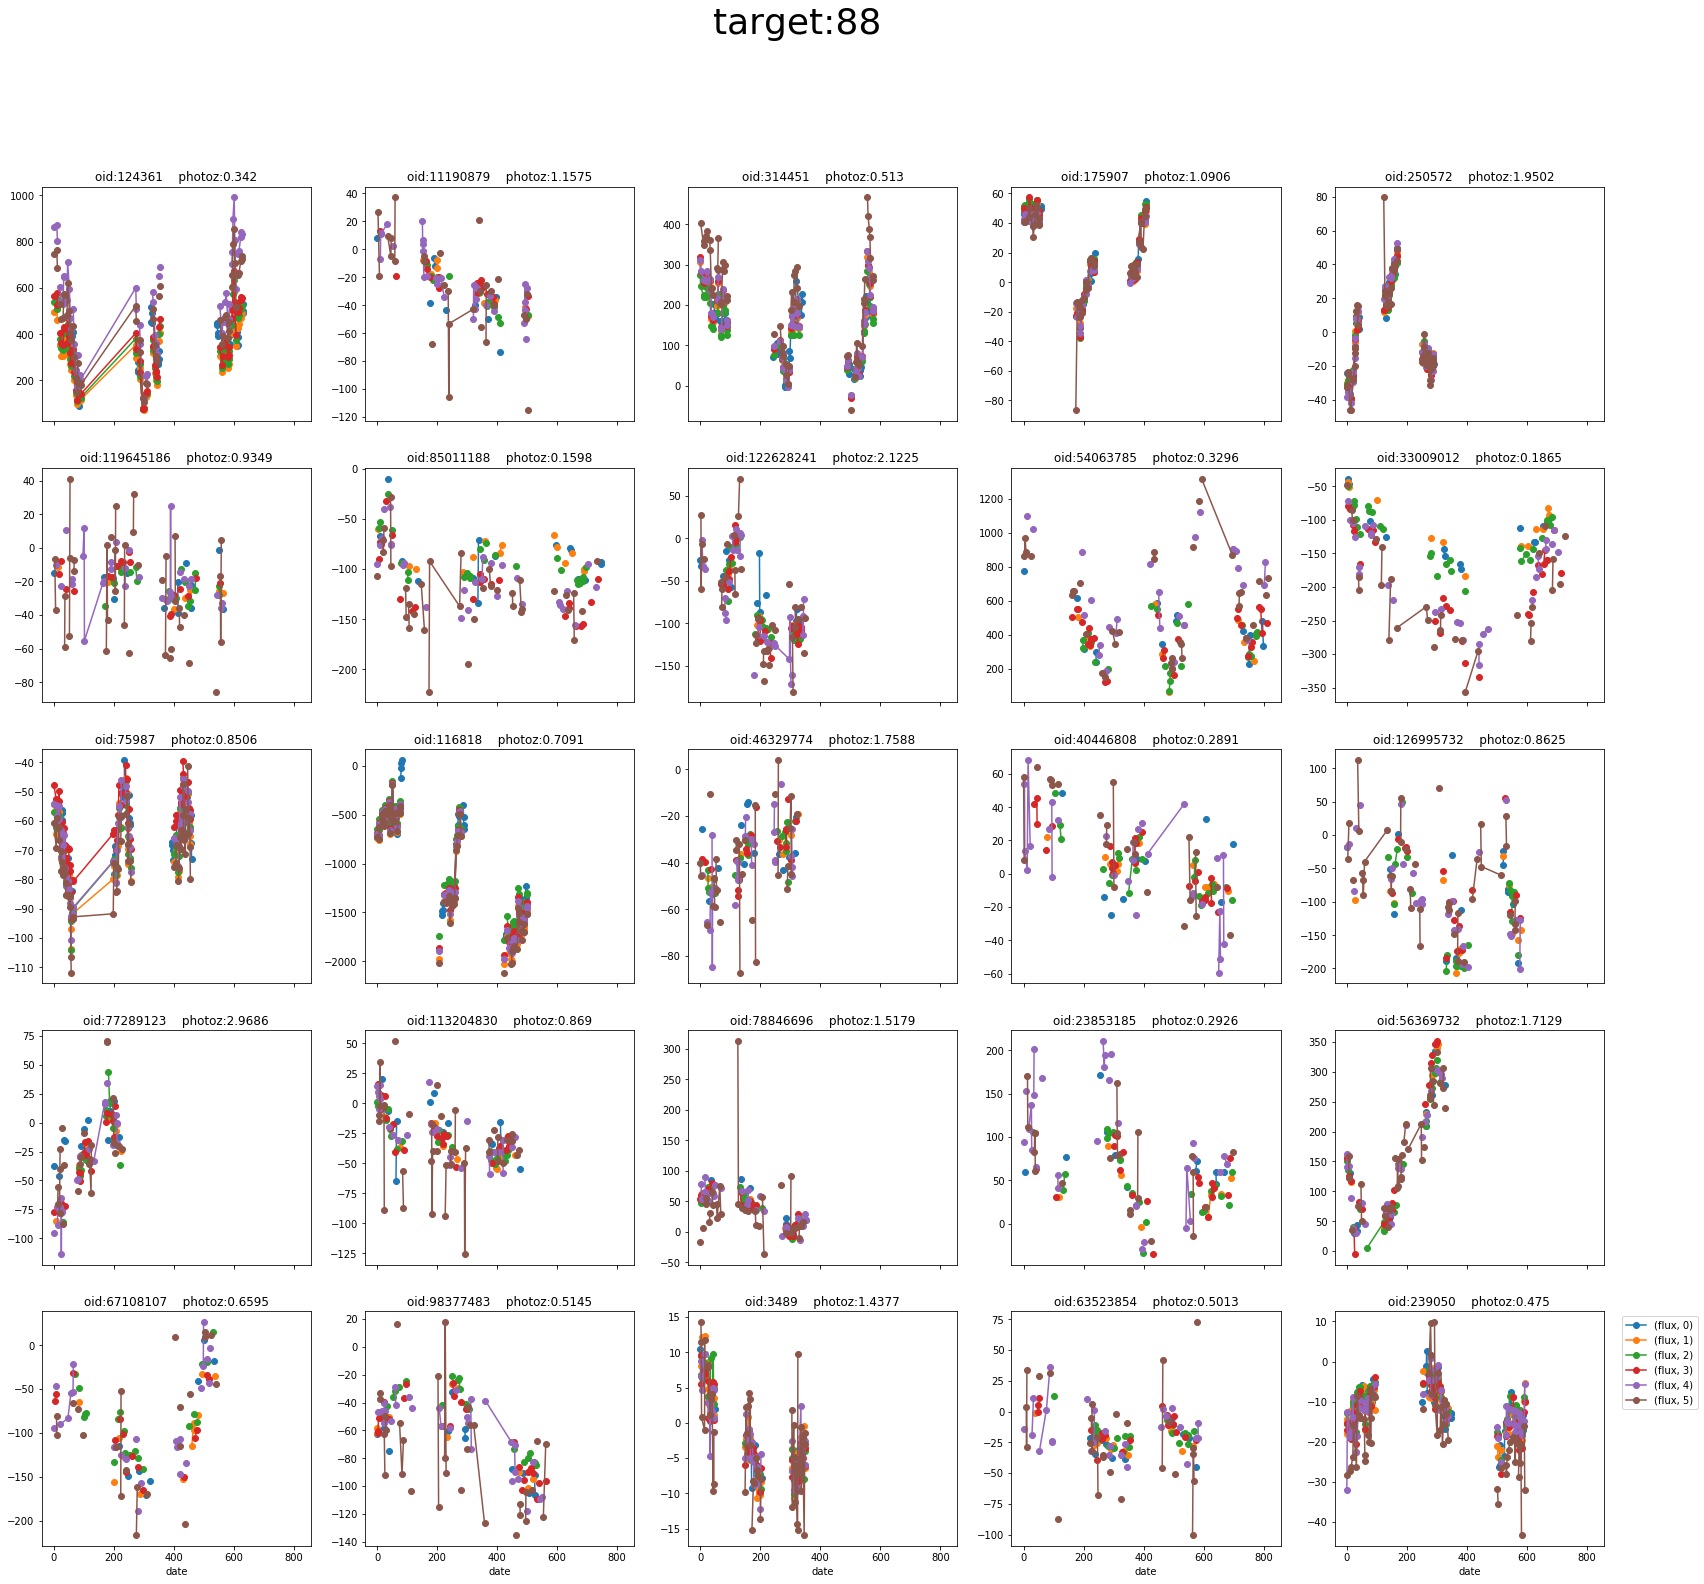

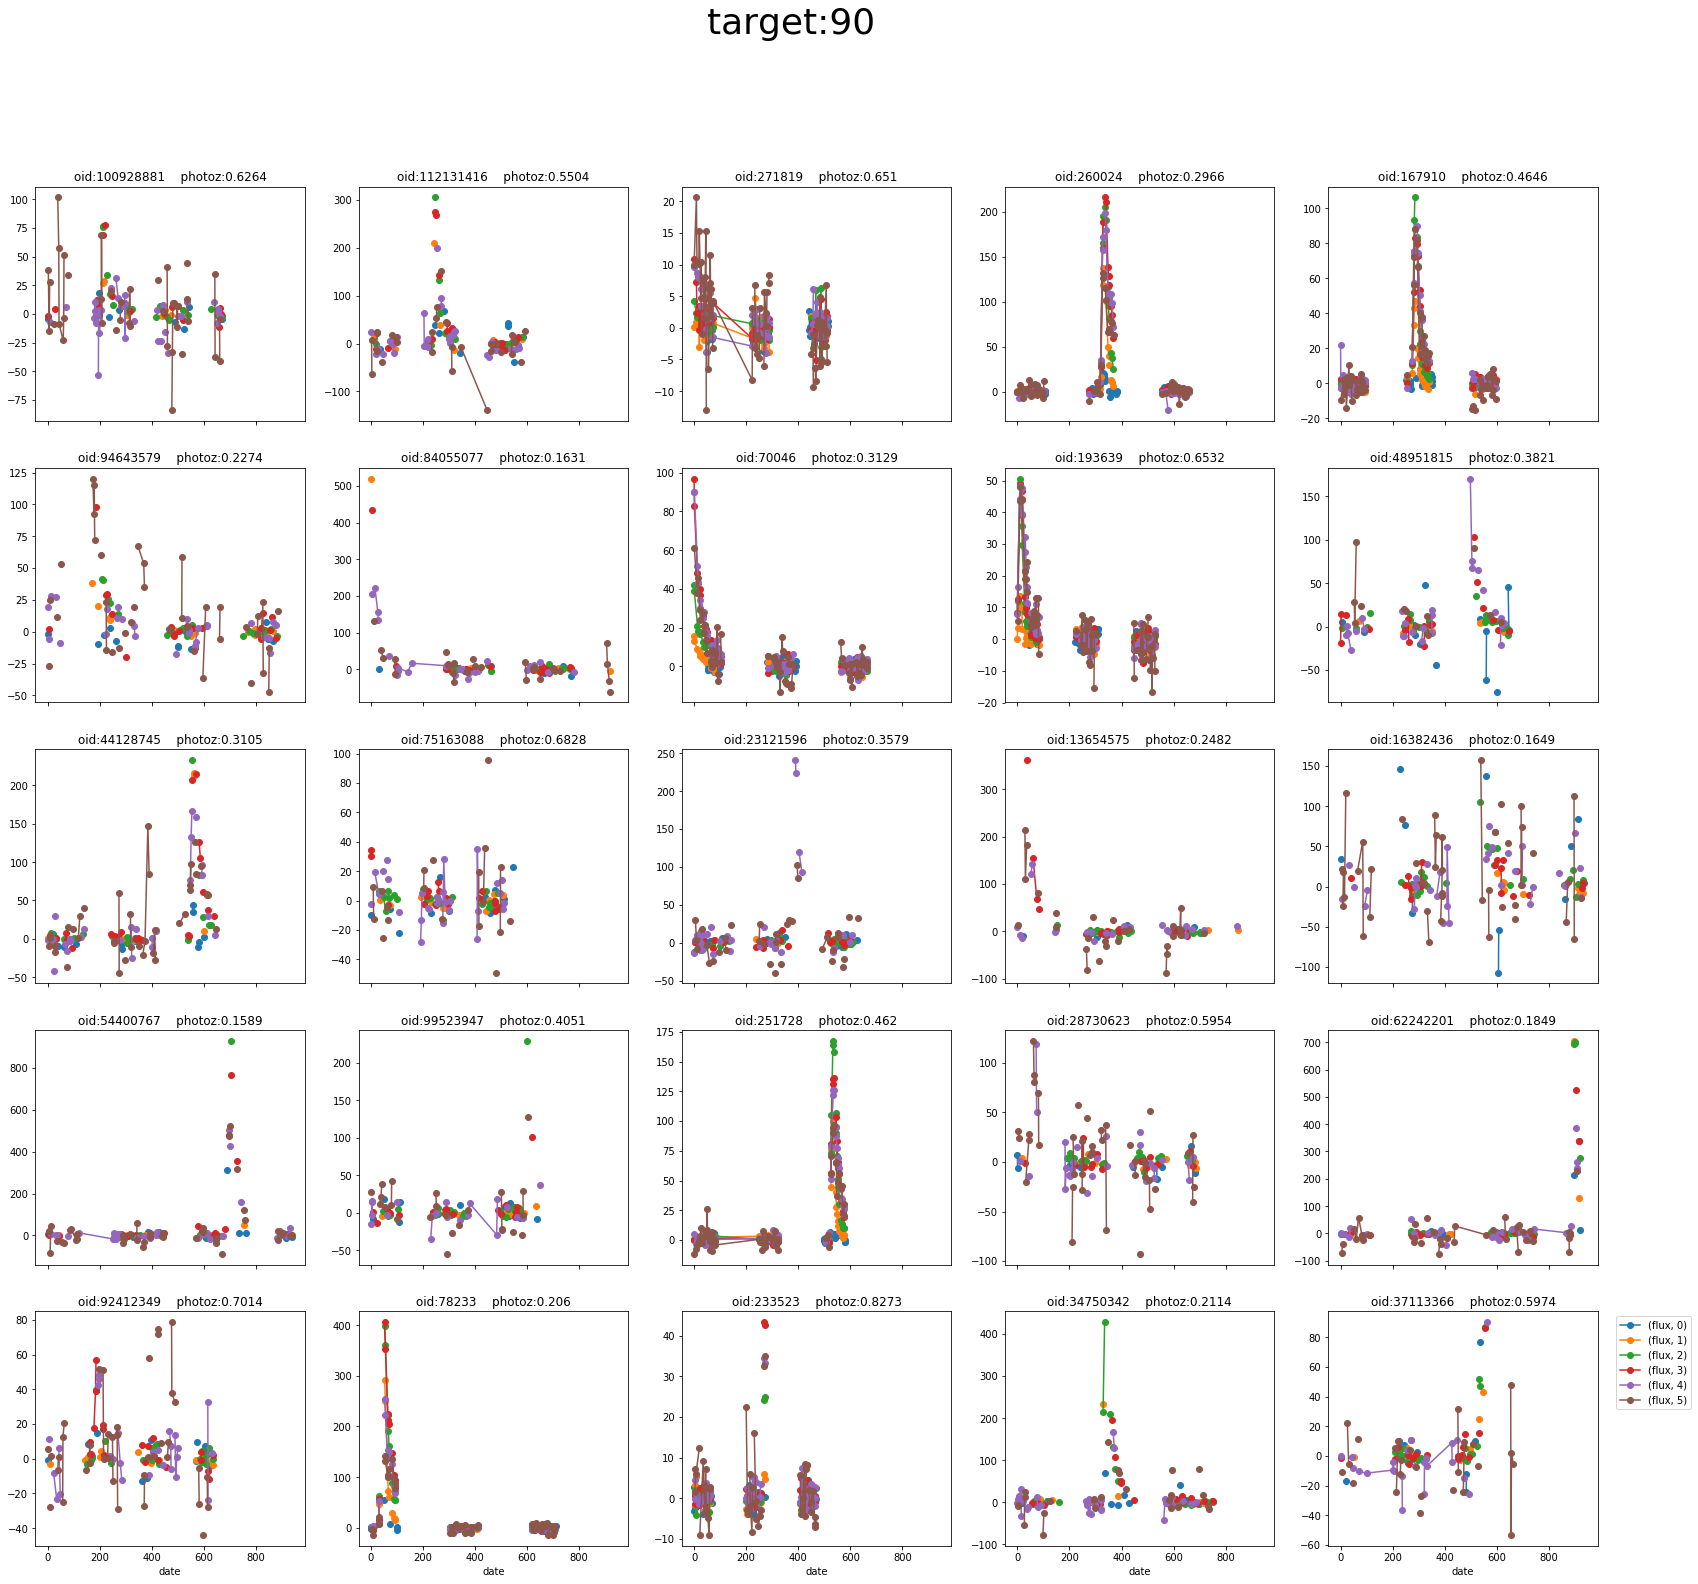

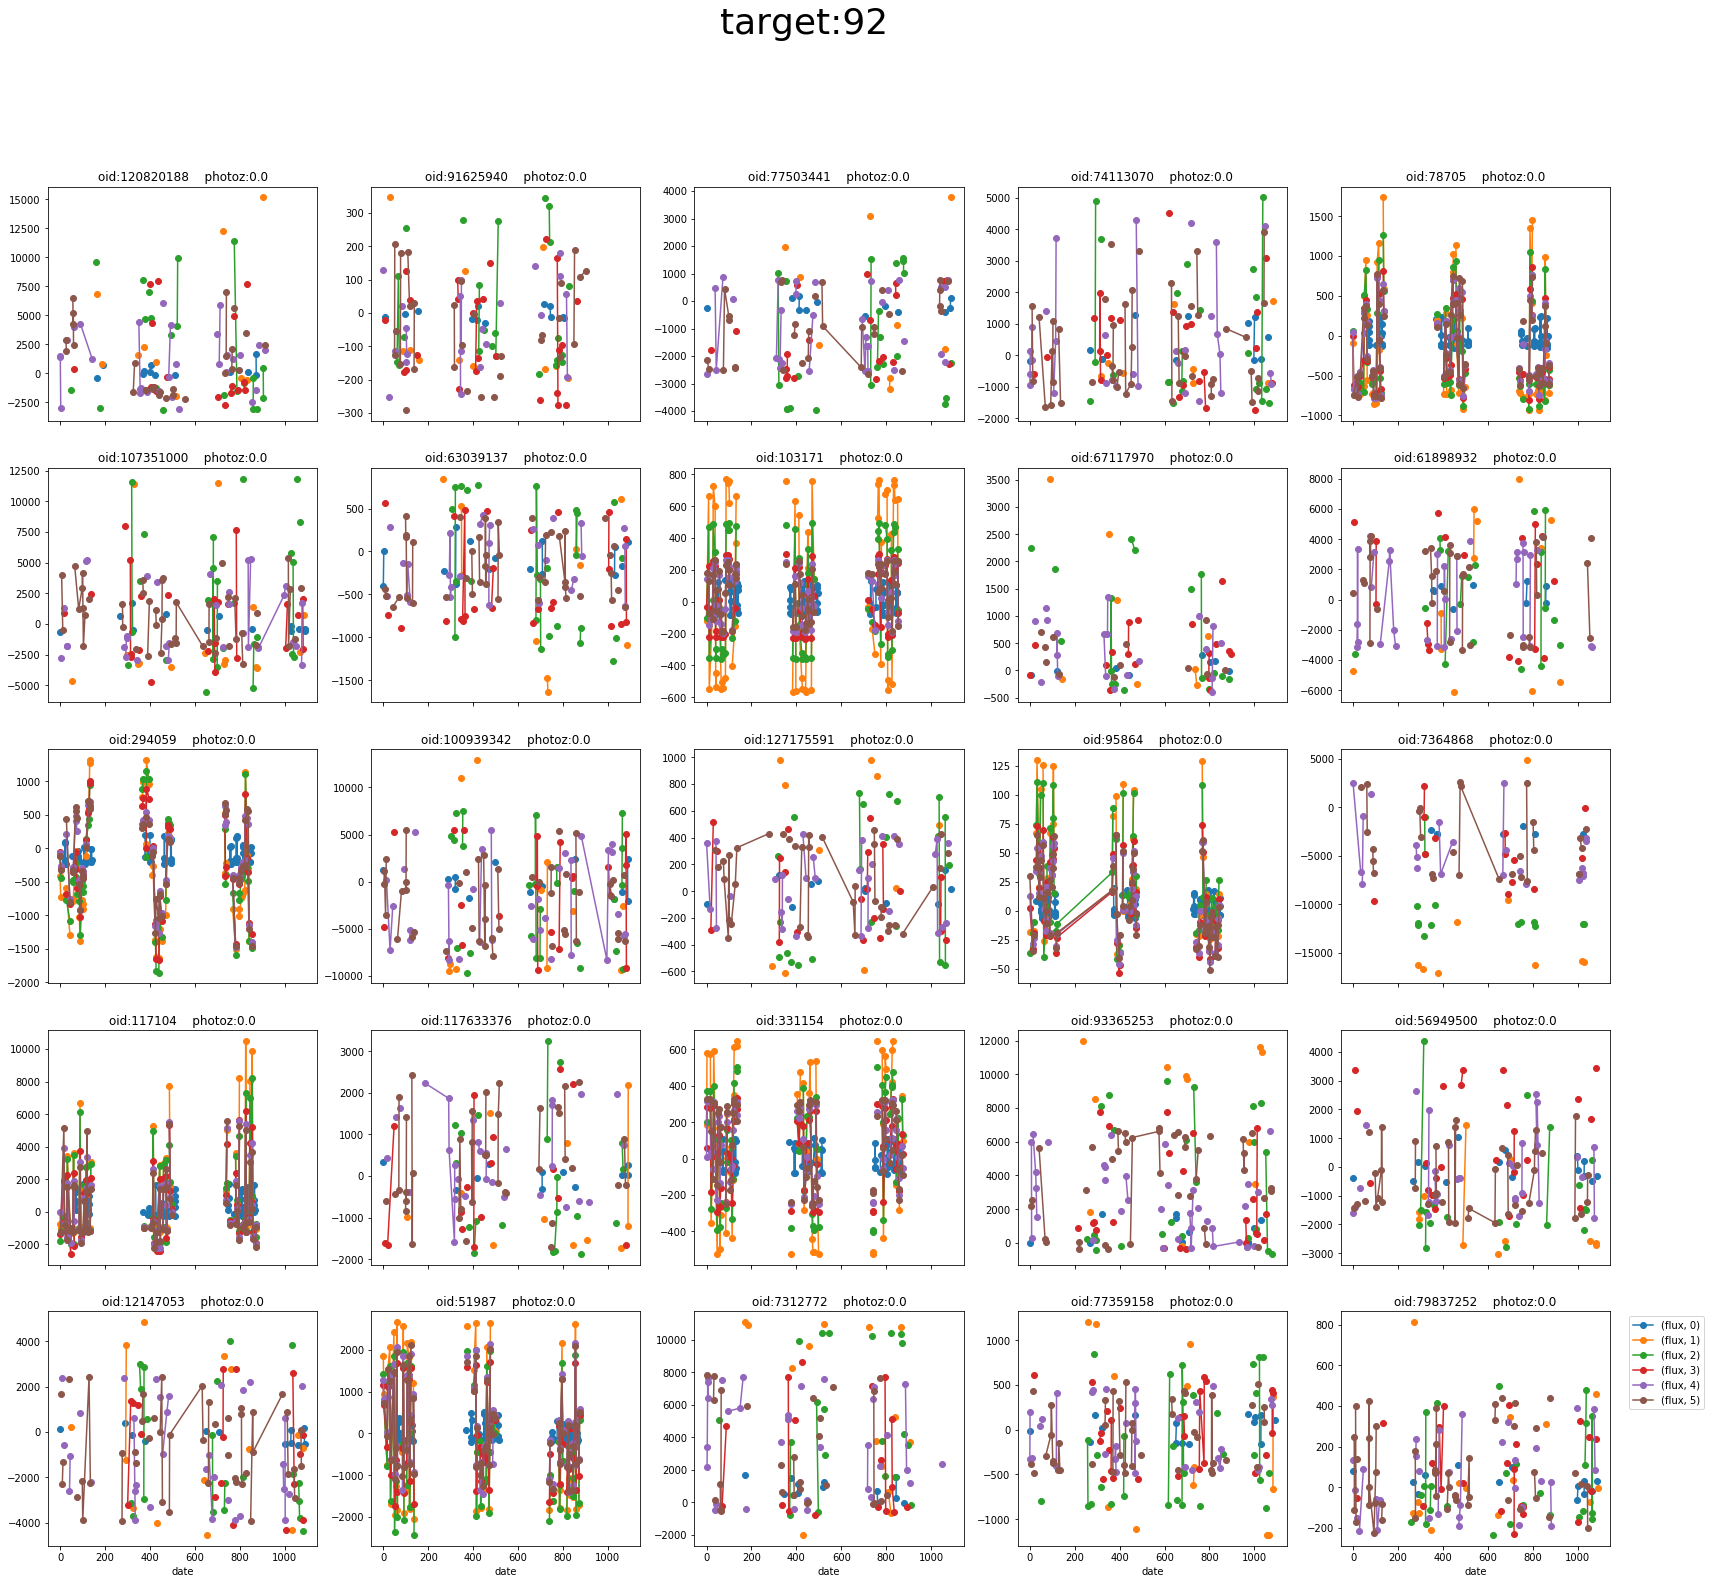

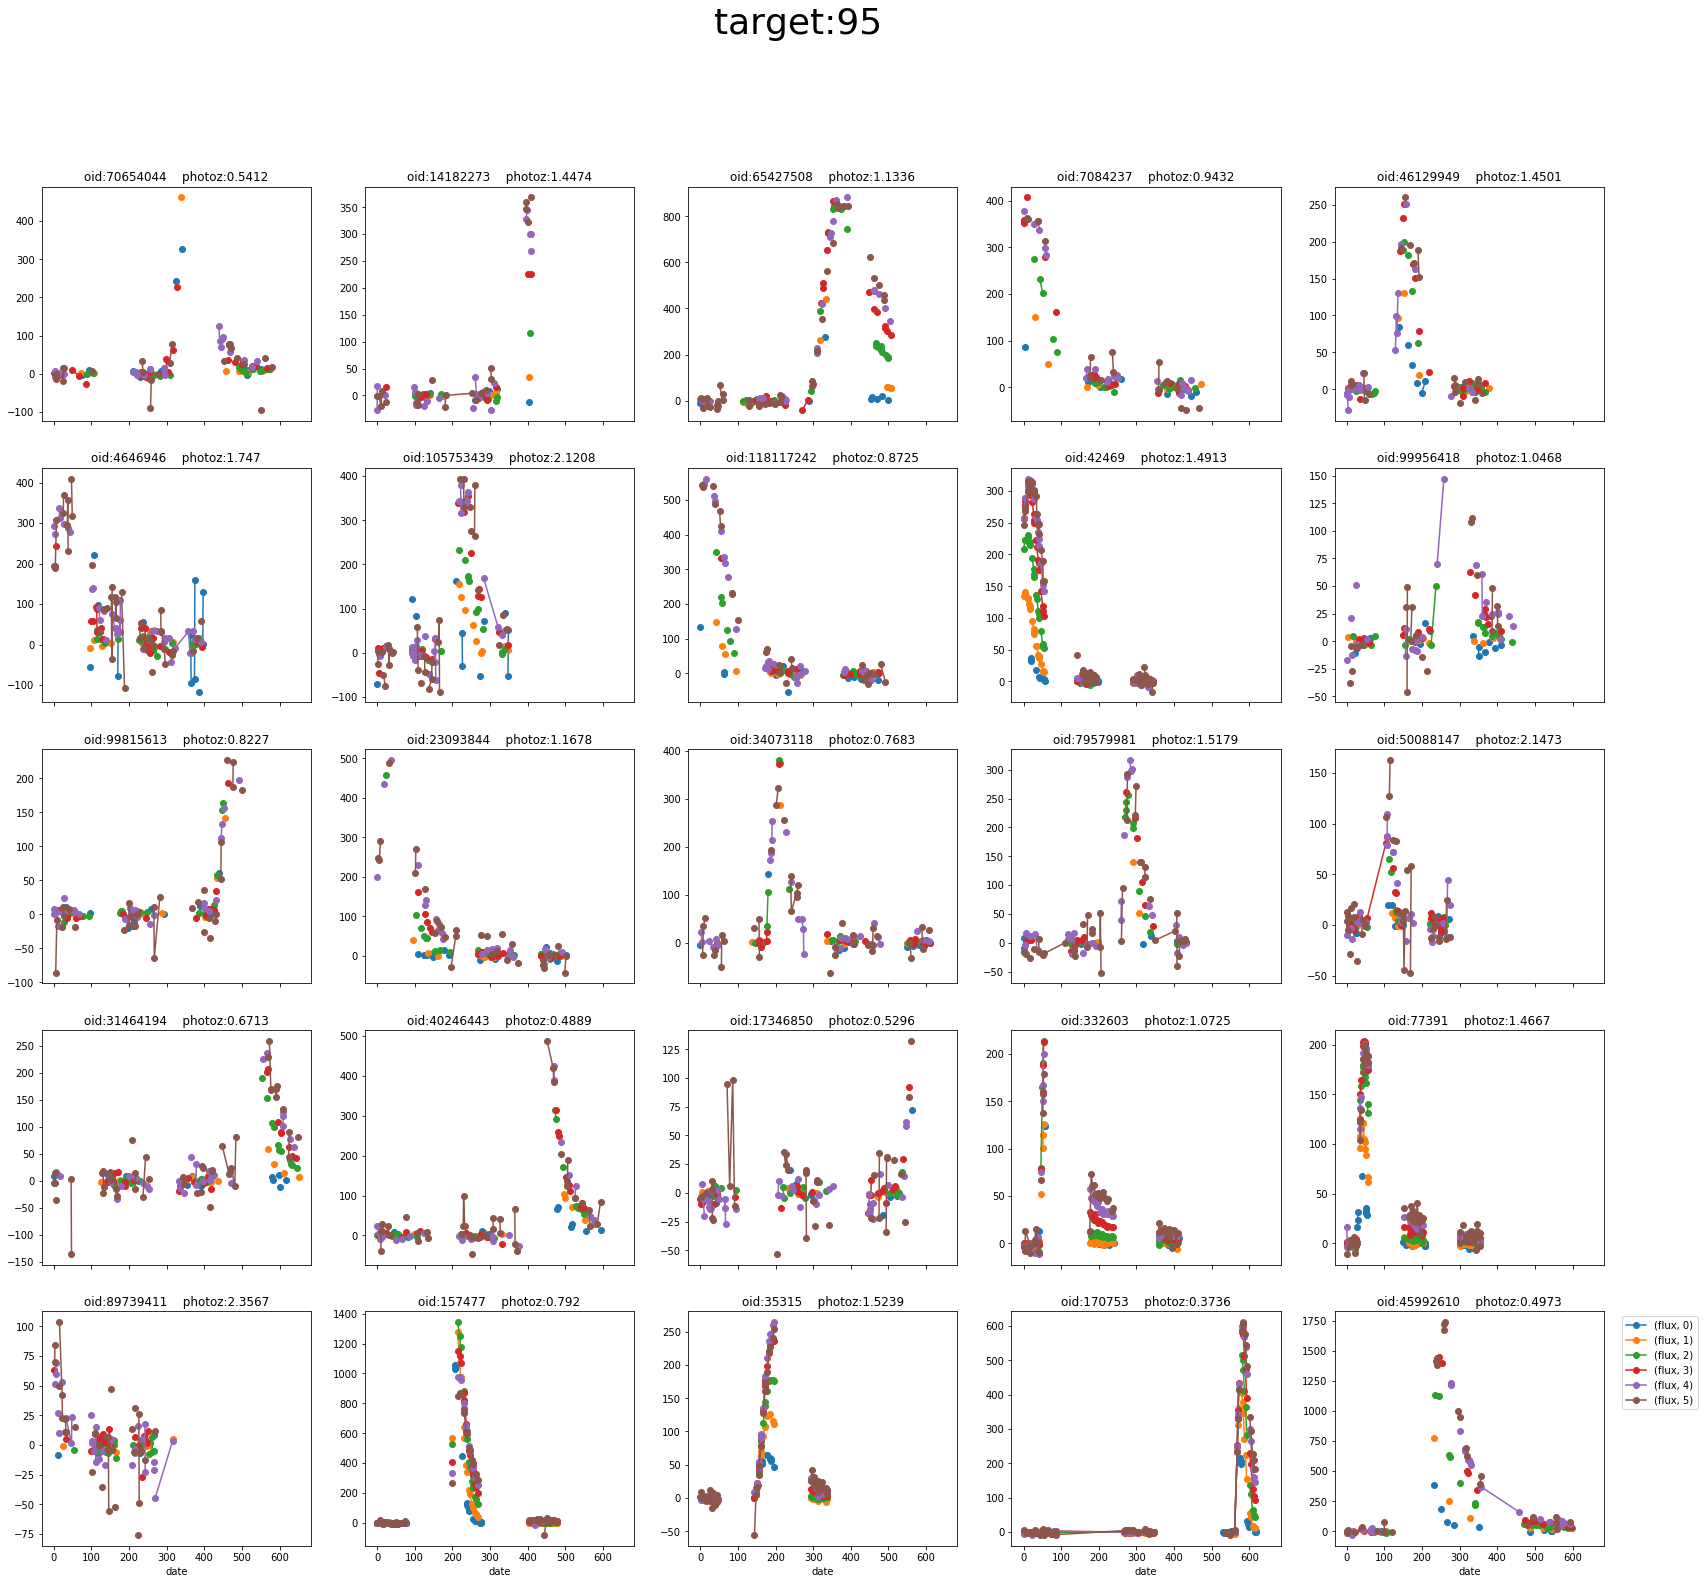

In [8]:
classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
M, N = 5, 5
for c in tqdm(classes):
    li = tr[tr.target==c].sample(M*N).object_id.tolist()
    fig, axes = plt.subplots(ncols=M, nrows=N, figsize=(28, 25), sharex=True)
    
    # プロット
    for i,(ax, oid) in enumerate(zip(axes.ravel(), li)):
        df=plt_obj(oid, return_df=True)
        
        
        photoz = tr.loc[tr.object_id==oid, 'hostgal_photoz'].values[0]

        if i==24:
            legend=True
        else:
            legend = False
        df.plot(ax=ax,  marker="o", legend=legend, title=f'oid:{oid}    photoz:{photoz}')
    
    fig.suptitle(f'target:{c}', fontsize=36)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    